# Patient Level Analysis

The dataset is imported into my local postgres SQL database in it's original form. I used SQL to do most of the data cleaning and created some new variables. You may refer to sql_pt_2.sql for the code.

**Our Data**

* Clinical and financial data of patients hospitalised for a certain (X) condition
* Per row per patient’s total bill per year
* 3,314 rows 
* 3,000 unique patients
* 5 year data (2011 - 2015)

**Variables**

* Number of encounter per year (continuous)
* More than 1 encounter per year (binary)
* Age (continuous)
* Age (<55, >55) (categorical)
* BMI (continuous)
* BMI Risk Level (categorical)
* Number of Medical History (continuous)
* Medical History 1 through 7 (binary)

Total number of data = 3,312 (per row per admission)

In [1]:
# import packages

import psycopg2
import pandas as pd
import numpy as np

# stats
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
from sklearn.feature_selection import chi2

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Processing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import linear_model


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# display options

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows',200)
pd.set_option('display.max_colwidth',200)

In [2]:
# connect to database

engine = psycopg2.connect("dbname=holmusk user=joannasyeow")
f = open("codes/sql_pt_2.sql", "r")
sql = f.read()
df = pd.read_sql(sql, con=engine)

In [3]:
# have a quick look at our data

df.head()

,id_,patient_id,no_enc,medical_history_1,medical_history_2_c,medical_history_3_c,medical_history_4,medical_history_5_c,medical_history_6,medical_history_7,no_med_hist,age_at_yr,age_grp,gender_c,race_c,resident_status_c,avg_bmi,bmi_risk,bmi_high,indian,chinese,malay,other,sg,pr,foreigner,not_sg,readm,tot_bill_yr
0,8461069832,00225710a878eff524a1d13be817e8e2,1,0,0,0,0,0,0,1,1,31,0,1,2,0,27.85,4,1,0,1,0,0,1,0,0,0,0,5190.57
1,5621737529,0029d90eb654699c18001c17efb0f129,1,0,1,0,0,0,1,0,2,69,1,1,2,0,34.80,4,1,0,1,0,0,1,0,0,0,0,22601.50
2,9921582850,0040333abd68527ecb53e1db9073f52e,1,0,1,0,0,0,0,1,2,41,0,0,1,0,26.87,3,0,1,0,0,0,1,0,0,0,0,17447.18
3,7239419545,00473b58e3dc8ae37b3cb34069705083,1,1,0,0,0,0,0,0,1,38,0,1,2,0,31.68,4,1,0,1,0,0,1,0,0,0,0,15285.88
4,9476531069,0078662d1d983dde68ea057c42d5b5cf,1,0,1,0,0,0,1,0,2,70,1,0,3,2,24.96,3,0,0,0,1,0,0,0,1,1,0,73477.87


In [4]:
df.describe()

,id_,no_enc,medical_history_1,medical_history_2_c,medical_history_3_c,medical_history_4,medical_history_5_c,medical_history_6,medical_history_7,no_med_hist,age_at_yr,age_grp,gender_c,race_c,resident_status_c,avg_bmi,bmi_risk,bmi_high,indian,chinese,malay,other,sg,pr,foreigner,not_sg,readm,tot_bill_yr
count,3.314000e+03,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000,3314.000000
mean,8.028419e+09,1.025951,0.173205,0.296319,0.138202,0.053108,0.059747,0.259505,0.259807,1.239891,52.491249,0.414906,0.501207,2.216657,0.246530,28.948401,3.554617,0.636391,0.099276,0.638503,0.208509,0.053712,0.800845,0.151780,0.047375,0.199155,0.025649,22426.325356
std,1.599729e+09,0.160899,0.378481,0.456702,0.345164,0.224283,0.237052,0.438429,0.438595,0.988355,14.681201,0.492780,0.500074,0.689808,0.529705,4.128680,0.643201,0.481111,0.299077,0.480507,0.406304,0.225482,0.399425,0.358862,0.212471,0.399425,0.158109,11013.200725
min,1.350319e+09,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,0.000000,0.000000,1.000000,0.000000,17.510000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2946.100000
25%,7.125563e+09,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,40.000000,0.000000,0.000000,2.000000,0.000000,26.152500,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,14969.707500
50%,8.395612e+09,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,51.000000,0.000000,1.000000,2.000000,0.000000,28.940000,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,20475.510000
75%,9.304884e+09,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,65.000000,1.000000,1.000000,3.000000,0.000000,31.717500,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,27254.155000
max,9.999633e+09,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,85.000000,1.000000,1.000000,4.000000,2.000000,46.680000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,98723.850000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3314 entries, 0 to 3313
Data columns (total 29 columns):
id_                    3314 non-null int64
patient_id             3314 non-null object
no_enc                 3314 non-null int64
medical_history_1      3314 non-null int64
medical_history_2_c    3314 non-null int64
medical_history_3_c    3314 non-null int64
medical_history_4      3314 non-null int64
medical_history_5_c    3314 non-null int64
medical_history_6      3314 non-null int64
medical_history_7      3314 non-null int64
no_med_hist            3314 non-null int64
age_at_yr              3314 non-null int64
age_grp                3314 non-null int64
gender_c               3314 non-null int64
race_c                 3314 non-null int64
resident_status_c      3314 non-null int64
avg_bmi                3314 non-null float64
bmi_risk               3314 non-null int64
bmi_high               3314 non-null int64
indian                 3314 non-null int64
chinese                3314 no

In [6]:
# check for duplicated rows

len(df.loc[df.duplicated(), :])

0

** Target Variable **

The distribution of the data is highly skewed to the right. A natural log is applied to the data to ensure approximate normality.

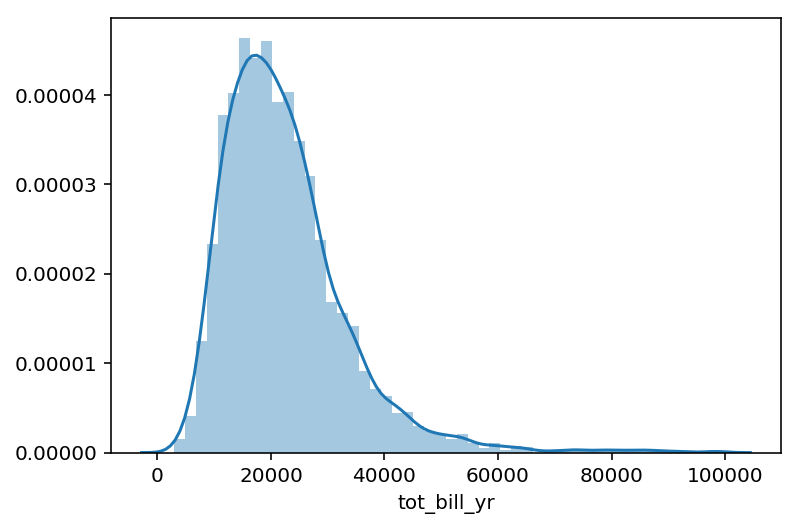

p-value (Sharpiro-Wilk Test):  4.203895392974451e-45


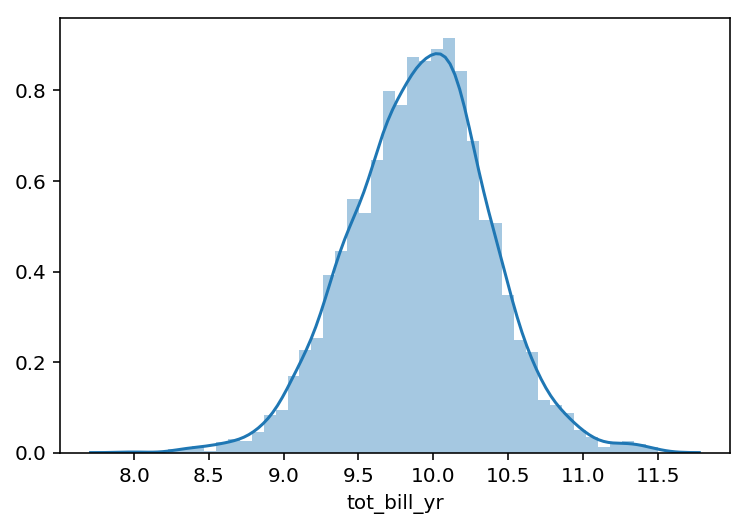

p-value (Sharpiro-Wilk Test):  0.000136852846480906


In [7]:
# Sharpiro-Wilk Test for Normality

sns.distplot(df['tot_bill_yr'])
plt.show()
print ('p-value (Sharpiro-Wilk Test): ',stats.shapiro(df['tot_bill_yr'])[1])

# Sharpiro-Wilk Test for Normality

sns.distplot(np.log(df['tot_bill_yr']))
plt.show()
print ('p-value (Sharpiro-Wilk Test): ',stats.shapiro(np.log(df['tot_bill_yr']))[1])

In [8]:
# create new target variable from 1_eda

df['log_bill'] = np.log(df['tot_bill_yr'])

# Number of encounters

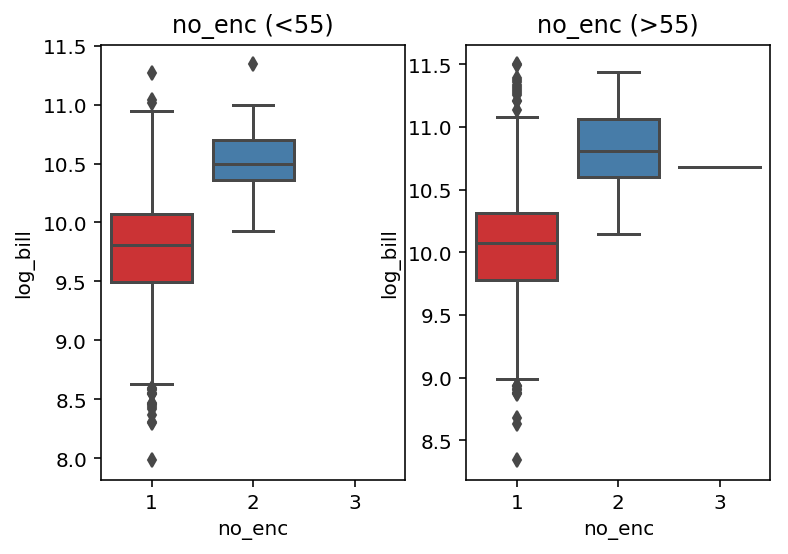


<55
Value Count:
no_enc
1    1716
2      45
Name: patient_id, dtype: int64

Mean Total Bills:
no_enc
1    19332.672672
2    38705.620667
Name: tot_bill_yr, dtype: float64

F: 134.0218654098311
P-value:  5.126439487960793e-30
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass

##########################
>55
Value Count:
no_enc
1    1219
2      39
3       1
Name: patient_id, dtype: int64

Mean Total Bills:
no_enc
1    25370.378667
2    52565.682564
3    43490.120000
Name: tot_bill_yr, dtype: float64

F: 62.32653663994557
P-value:  1.2354270823948245e-26
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


/Users/joannasyeow/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/joannasyeow/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [9]:
fig, ax =plt.subplots(1,2)
sns.boxplot(y=df[df['age_grp']==0]['log_bill'],x=df['no_enc'], ax=ax[0],palette="Set1").set_title("no_enc (<55)")
sns.boxplot(y=df[df['age_grp']==1]['log_bill'],x=df['no_enc'], ax=ax[1],palette="Set1").set_title("no_enc (>55)")
plt.show()

print()
print('<55')
print('Value Count:')
print(df[df['age_grp']==0].groupby('no_enc')['patient_id'].nunique())
print()
print('Mean Total Bills:')
print(df[df['age_grp']==0].groupby('no_enc')['tot_bill_yr'].mean())
print()

# stats f_oneway function
fvalue, pvalue = stats.f_oneway(df[df['age_grp']==0][df['no_enc'] == 1]['log_bill'],df[df['age_grp']==0][df['no_enc'] == 2]['log_bill'])
print('F:',fvalue)
print('P-value: ',pvalue)
if pvalue < 0.01 :
    print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
    print('Hypothesis: Pass')
else:
    print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')

print()   
print('##########################')    
print('>55')
print('Value Count:')
print(df[df['age_grp']==1].groupby('no_enc')['patient_id'].nunique())
print()
print('Mean Total Bills:')
print(df[df['age_grp']==1].groupby('no_enc')['tot_bill_yr'].mean())
print()
# stats f_oneway function
fvalue, pvalue = stats.f_oneway(df[df['age_grp']==1][df['no_enc'] == 1]['log_bill'],df[df['age_grp']==1][df['no_enc'] == 2]['log_bill'],df[df['age_grp']==1][df['no_enc'] == 3]['log_bill'])
print('F:',fvalue)
print('P-value: ',pvalue)
if pvalue < 0.01 :
    print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
    print('Hypothesis: Pass')
else:
    print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')


In [10]:
print('Value Count:')
print(df.groupby('no_enc')['patient_id'].nunique())
print()
print('Mean Total Bills:')
print(df.groupby('no_enc')['tot_bill_yr'].mean())
print()

# number of encounters

# stats f_oneway function
fvalue, pvalue = stats.f_oneway(df[df['no_enc'] == 1]['log_bill'],df[df['no_enc'] == 2]['log_bill'],df[df['no_enc'] == 3]['log_bill'])
print('F:',fvalue)
print('P-value: ',pvalue)
if pvalue < 0.01 :
    print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
    print('Hypothesis: Pass')
else:
    print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')


Value Count:
no_enc
1    2928
2      84
3       1
Name: patient_id, dtype: int64

Mean Total Bills:
no_enc
1    21828.906027
2    45140.649405
3    43490.120000
Name: tot_bill_yr, dtype: float64

F: 122.83687109051233
P-value:  3.459666718028266e-52
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


                   medical_history_1  medical_history_6  medical_history_7  \
medical_history_1           0.000000       8.522587e-01           0.513132   
medical_history_6           0.860098       0.000000e+00           0.964890   
medical_history_7           0.536067       9.648970e-01           0.000000   
bmi_high                    0.742419       7.544613e-01           0.963060   
age_grp                     0.047228       3.619291e-01           0.939487   
readm                       0.003221       6.765613e-10           0.000225   
foreigner                   0.703154       4.956648e-01           0.343009   
malay                       0.815930       8.405709e-01           0.240631   

                   bmi_high   age_grp         readm  foreigner     malay  
medical_history_1  0.620188  0.018336  6.655725e-03   0.722583  0.811945  
medical_history_6  0.655357  0.305058  7.443508e-08   0.548042  0.845726  
medical_history_7  0.947315  0.931954  1.301389e-03   0.403239  0.256480

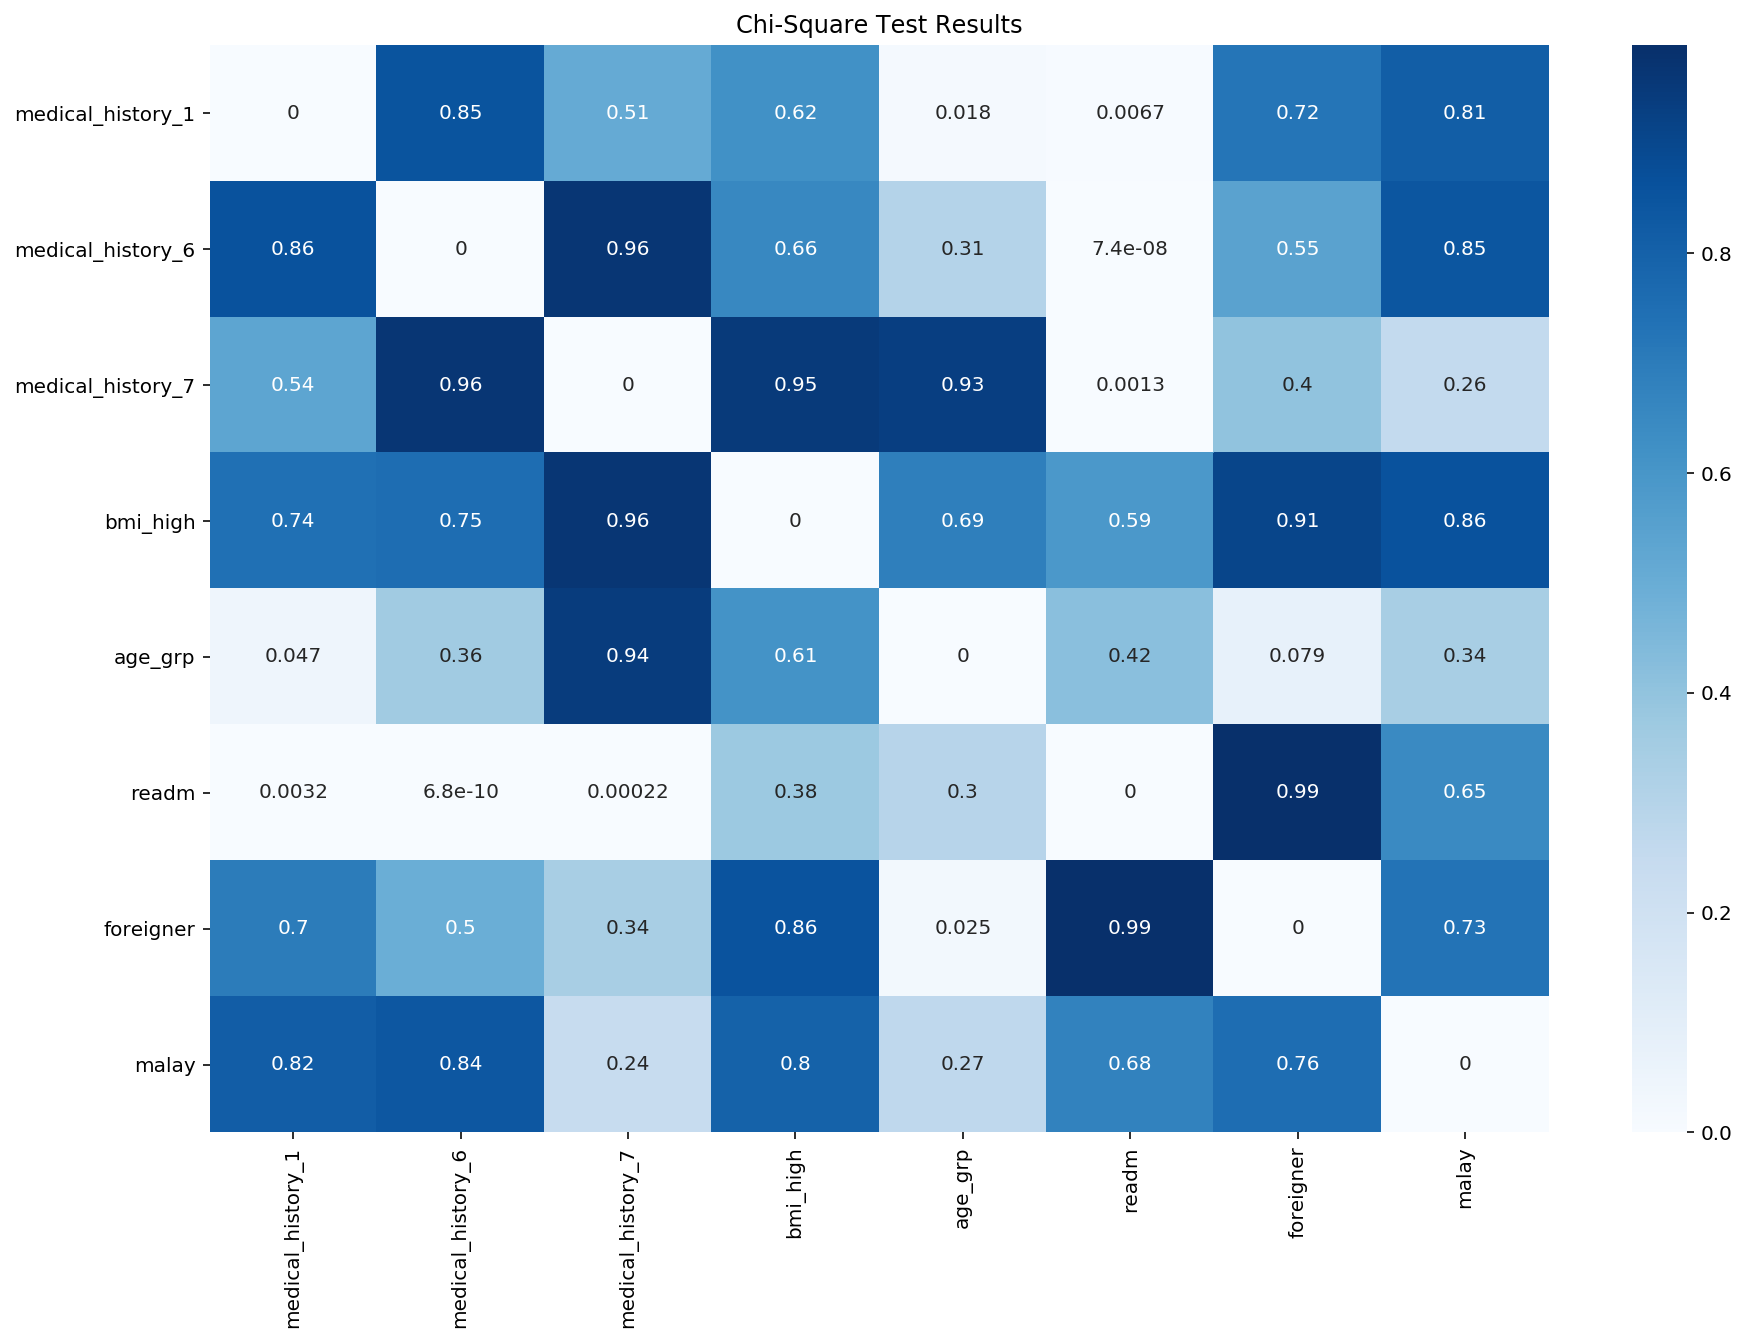

In [11]:
# CHI 2 Test 

A = df[['medical_history_1','medical_history_6','medical_history_7','bmi_high','age_grp','readm','foreigner','malay']]

resultant = pd.DataFrame(data=[(0 for i in range(len(A.columns))) for i in range(len(A.columns))], 
                         columns=list(A.columns))
resultant.set_index(pd.Index(list(A.columns)), inplace = True)

# Finding p_value for all columns and putting them in the resultant matrix
for i in list(A.columns):
    for j in list(A.columns):
        if i != j:
            chi2_val, p_val = chi2(np.array(A[i]).reshape(-1, 1), np.array(A[j]).reshape(-1, 1))
            resultant.loc[i,j] = p_val
print(resultant)

# Plotting a heatmap
# fig = plt.figure(figsize=(15,10))
sns.heatmap(resultant, annot=True, cmap='Blues')
plt.title('Chi-Square Test Results')
plt.show()

# Target Variable

Since the number of encounter per year has high multicolinearity with medical histories, we can take this variable into account by dividng the total bills per year by the number of encounters.

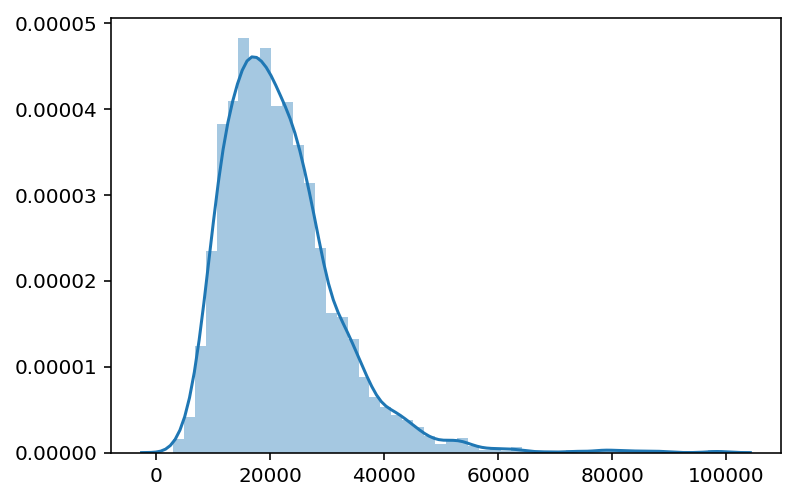

p-value (Sharpiro-Wilk Test):  9.164491956684304e-43


In [12]:
# Sharpiro-Wilk Test for Normality

sns.distplot(df['tot_bill_yr'] / df['no_enc'])
plt.show()
print ('p-value (Sharpiro-Wilk Test): ',stats.shapiro(df['tot_bill_yr'] / df['no_enc'])[1])

Similarly, I will be applying log transformation for the target variable

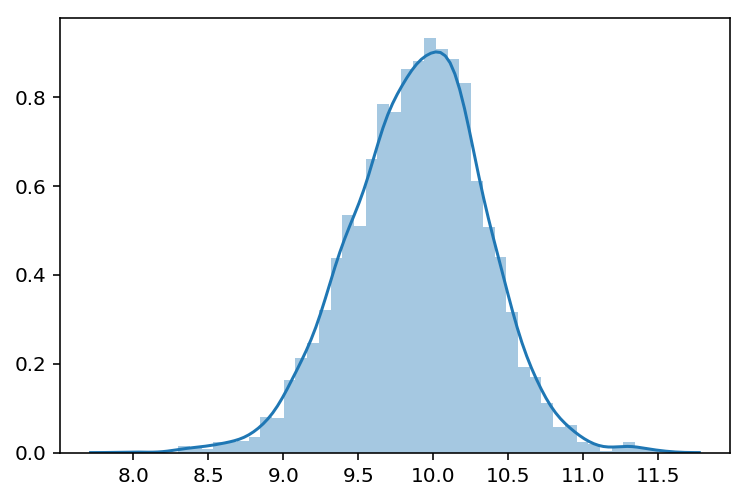

p-value (Sharpiro-Wilk Test):  4.297342456993647e-06


In [13]:
# Sharpiro-Wilk Test for Normality

sns.distplot(np.log(df['tot_bill_yr'] / df['no_enc']))
plt.show()
print ('p-value (Sharpiro-Wilk Test): ',stats.shapiro(np.log(df['tot_bill_yr'] / df['no_enc']))[1])


Now that looks better !

In [14]:
# create new target variable
df['log_bill'] = np.log((df['tot_bill_yr'] / df['no_enc']))

In [15]:
df['tot_bill_yr'] = df['tot_bill_yr'] / df['no_enc']

# Medical History Analysis

In [16]:
hist_col = ['no_med_hist','medical_history_1','medical_history_2_c','medical_history_3_c','medical_history_4','medical_history_5_c','medical_history_6','medical_history_7']

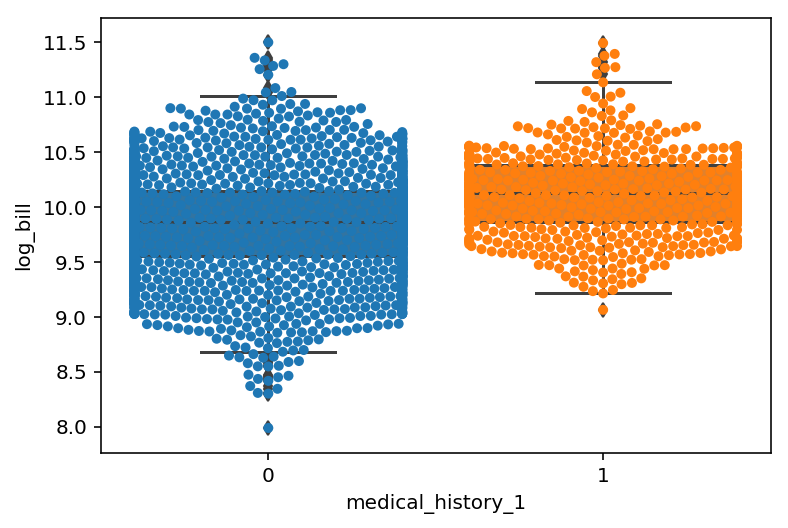

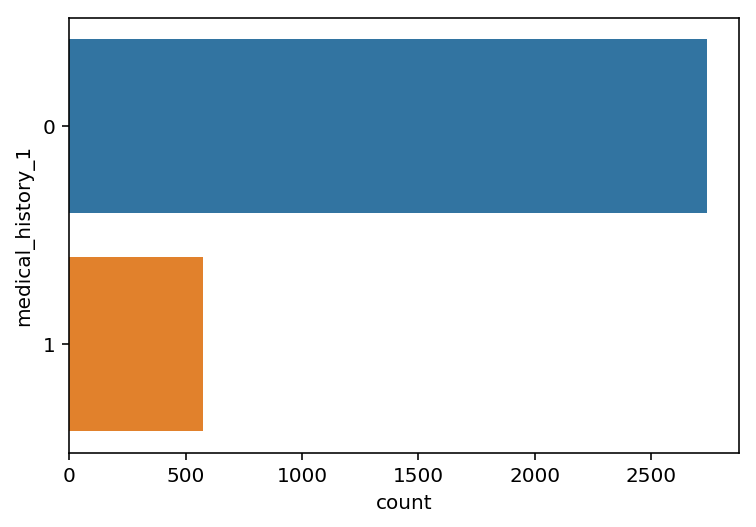


Value Count:
medical_history_1
0    2525
1     562
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_1
0    20796.960436
1    26850.644506
Name: tot_bill_yr, dtype: float64



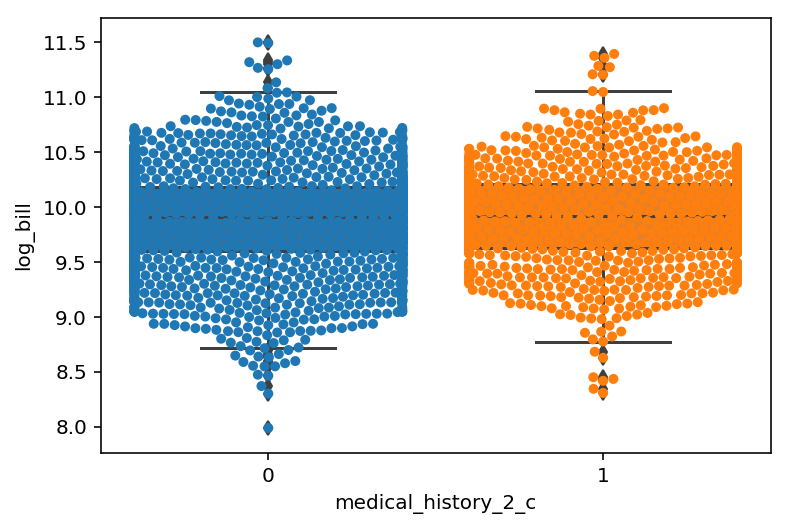

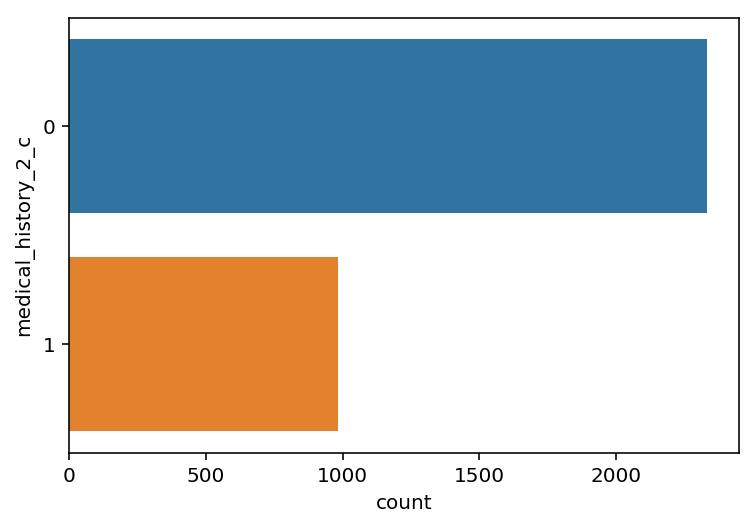


Value Count:
medical_history_2_c
0    2176
1     953
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_2_c
0    21630.063345
1    22357.060918
Name: tot_bill_yr, dtype: float64



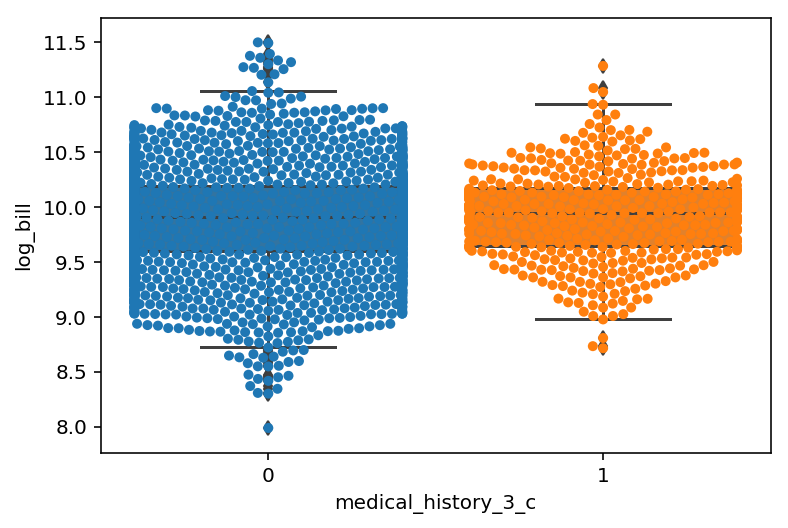

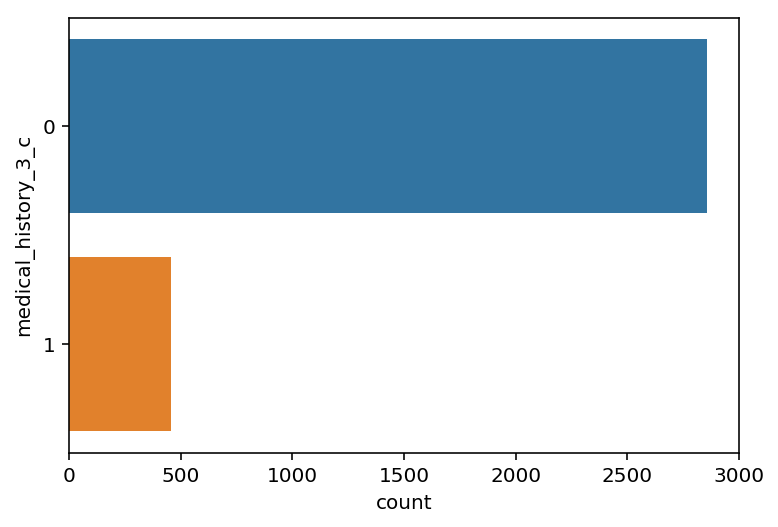


Value Count:
medical_history_3_c
0    2621
1     455
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_3_c
0    21787.763863
1    22205.432205
Name: tot_bill_yr, dtype: float64



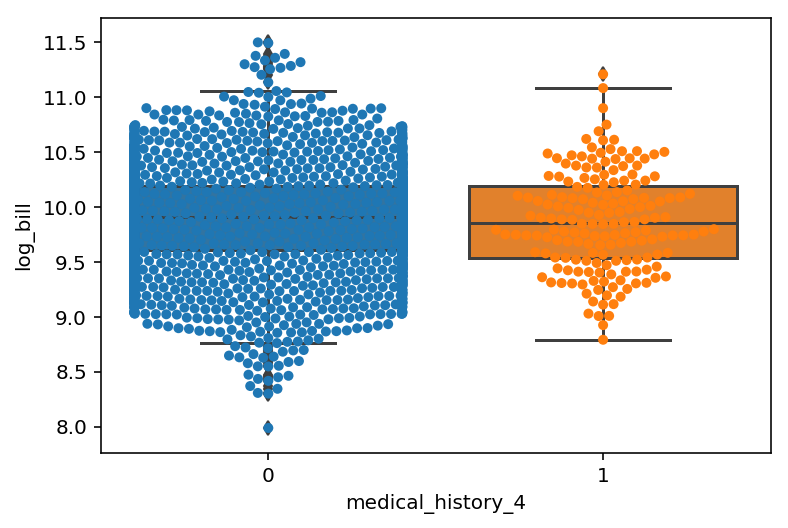

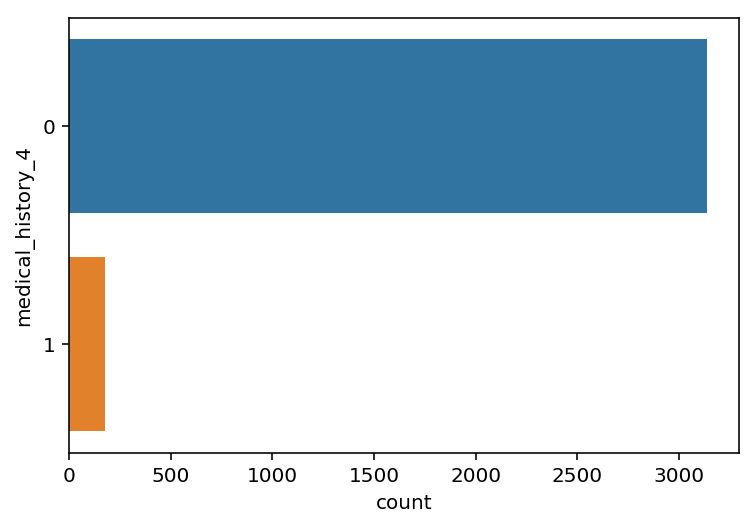


Value Count:
medical_history_4
0    2849
1     175
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_4
0    21865.971529
1    21480.243665
Name: tot_bill_yr, dtype: float64



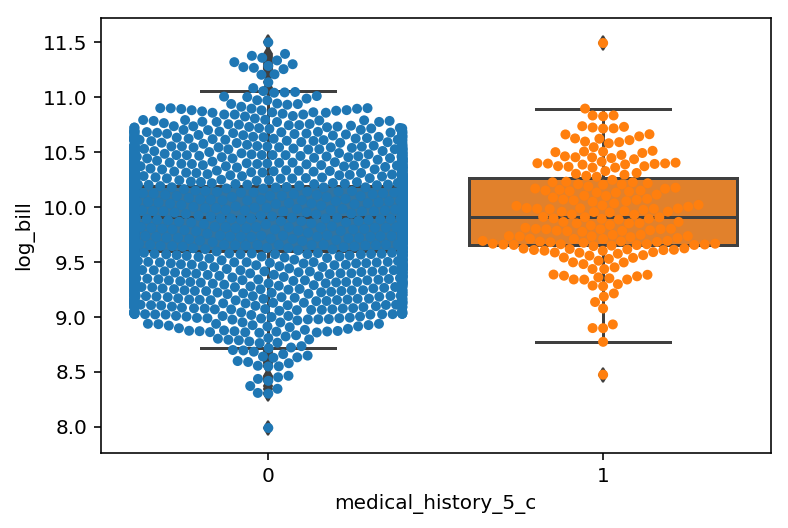

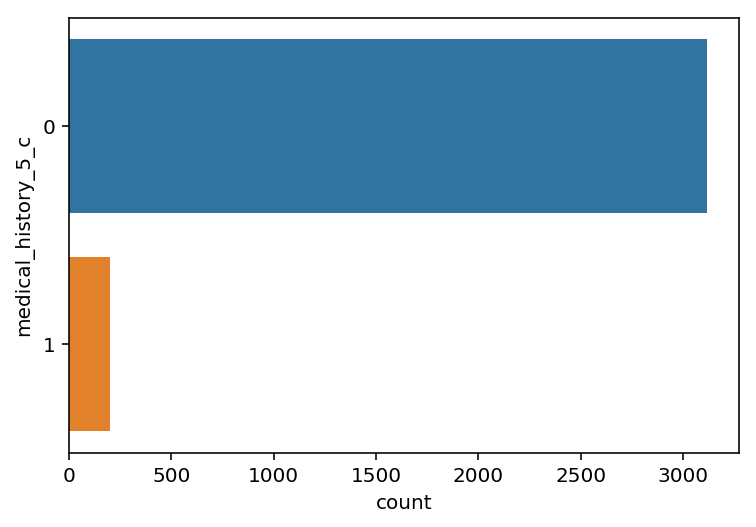


Value Count:
medical_history_5_c
0    2840
1     196
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_5_c
0    21763.905122
1    23129.359495
Name: tot_bill_yr, dtype: float64



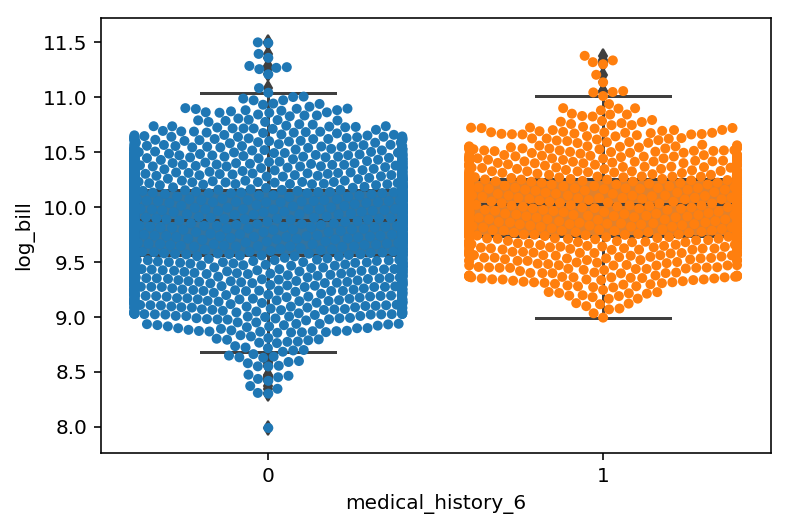

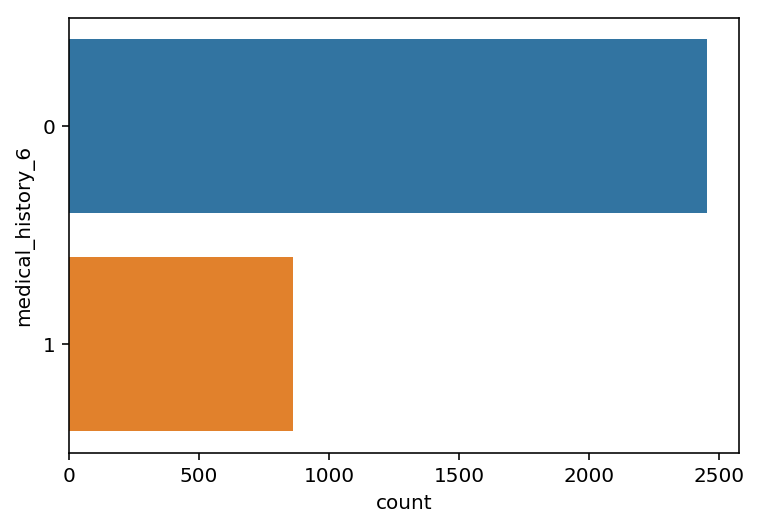


Value Count:
medical_history_6
0    2287
1     839
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_6
0    21028.842622
1    24175.769473
Name: tot_bill_yr, dtype: float64



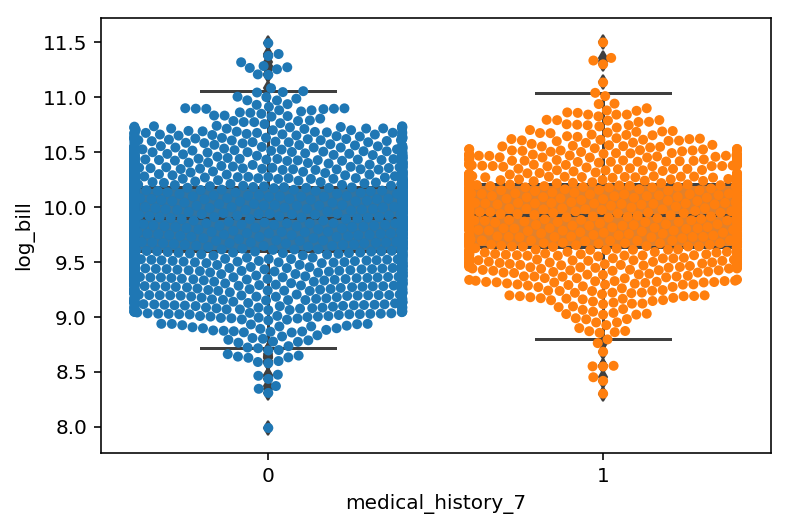

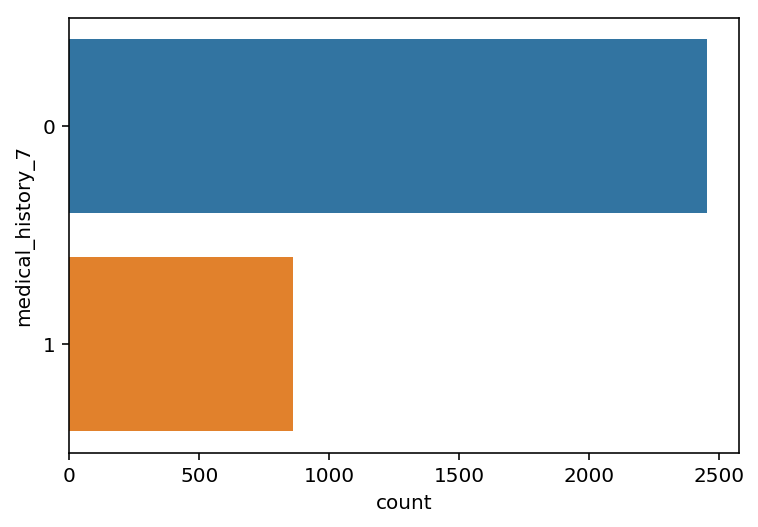


Value Count:
medical_history_7
0    2274
1     842
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_7
0    21621.269364
1    22484.283149
Name: tot_bill_yr, dtype: float64



In [17]:
# descriptive analysis for Medical History data

for c in hist_col: 
    if c is not 'no_med_hist':
        sns.boxplot(y=df['log_bill'],x=df[c])
        sns.swarmplot(y=df['log_bill'],x=df[c])
        plt.show()
        sns.countplot(y = df[c])
        plt.show()
        print()
        print('Value Count:')
        print(df.groupby(c)['patient_id'].nunique())
        print()
        print('Mean Total Bills:')
        print(df.groupby(c)['tot_bill_yr'].mean())
        print()

In [18]:
# ONE WAY ANOVA for Medical Historys

for c in hist_col:
    if c != 'no_med_hist':
        # stats f_oneway function
        fvalue, pvalue = stats.f_oneway(df[df[c] == 0]['log_bill'],df[df[c] == 1]['log_bill'])
        print('----------')
        print(c)
        print('----------')
        print('F:',fvalue)
        print('P-value: ',pvalue)
        if pvalue < 0.01 :
            print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
            print('Hypothesis: Pass')
        else:
            print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')

----------
medical_history_1
----------
F: 191.58244058465755
P-value:  2.127405494104095e-42
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass
----------
medical_history_2_c
----------
F: 2.9565250000924506
P-value:  0.0856250121617966
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.
----------
medical_history_3_c
----------
F: 2.684273106331624
P-value:  0.10143844727863685
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.
----------
medical_history_4
----------
F: 0.373160104060665
P-value:  0.5413286779060178
Since pvalue is > 0.01, we are unable to reject

### Taking a deeper look into Number of Medical History, Medical History 1 and Medical History 6

** Number of medical history **

R:  0.18924441371086292
P-value:  4.286584562808156e-28


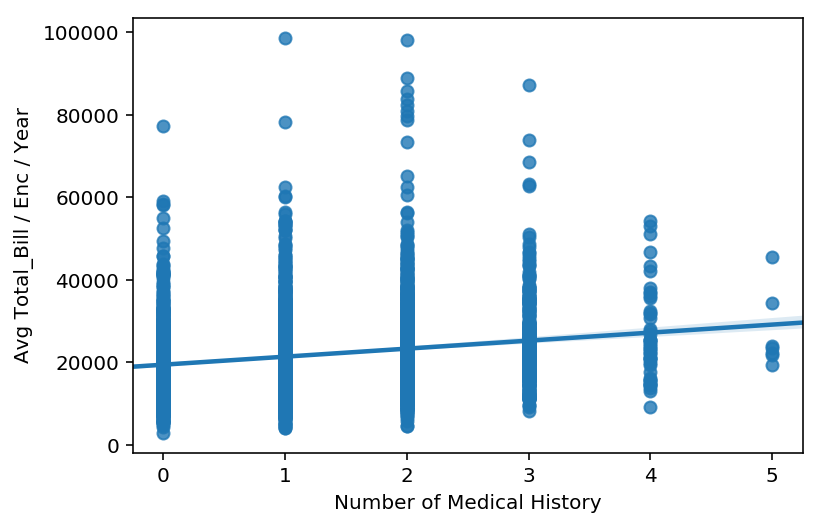

In [19]:
# Pearson Corrleation Coefficient on number of medical history
print ('R: ',stats.pearsonr(df['no_med_hist'], df['tot_bill_yr'])[0])
print ('P-value: ',stats.pearsonr(df['no_med_hist'], df['tot_bill_yr'])[1])

b = sns.regplot(df['no_med_hist'],df['tot_bill_yr'])
b.set_xlabel("Number of Medical History",fontsize=10)
b.set_ylabel("Avg Total_Bill / Enc / Year",fontsize=10)
plt.show()

In [20]:
# ONE WAY ANOVA for Number of Medical History

# stats f_oneway function
fvalue, pvalue = stats.f_oneway(df[df['no_med_hist'] == 0]['log_bill'],df[df['no_med_hist'] == 1]['log_bill'],df[df['no_med_hist'] == 2]['log_bill'],df[df['no_med_hist'] == 3]['log_bill'],df[df['no_med_hist'] == 4]['log_bill'],df[df['no_med_hist'] == 5]['log_bill'],)
print('F:',fvalue)
print('P-value: ',pvalue)
if pvalue < 0.01 :
    print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
    print('Hypothesis: Pass')
else:
    print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')

F: 29.118549484842564
P-value:  5.149610334378003e-29
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


** Medical History 1, 6  **

In [21]:
# Medical History 1

print(( df[df['medical_history_1'] == 1]['tot_bill_yr'].sum() / df['tot_bill_yr'].sum() ) * 100,'% of total bills came from patients with medical_history_1')

21.28885904163055 % of total bills came from patients with medical_history_1


In [22]:
# Medical History 6

print(( df[df['medical_history_6'] == 1]['tot_bill_yr'].sum() / df['tot_bill_yr'].sum() ) * 100,'% of total bills came from patients with medical_history_6')

28.718684091843116 % of total bills came from patients with medical_history_6


In [23]:
sns.set(rc={"figure.figsize": (15, 10)})

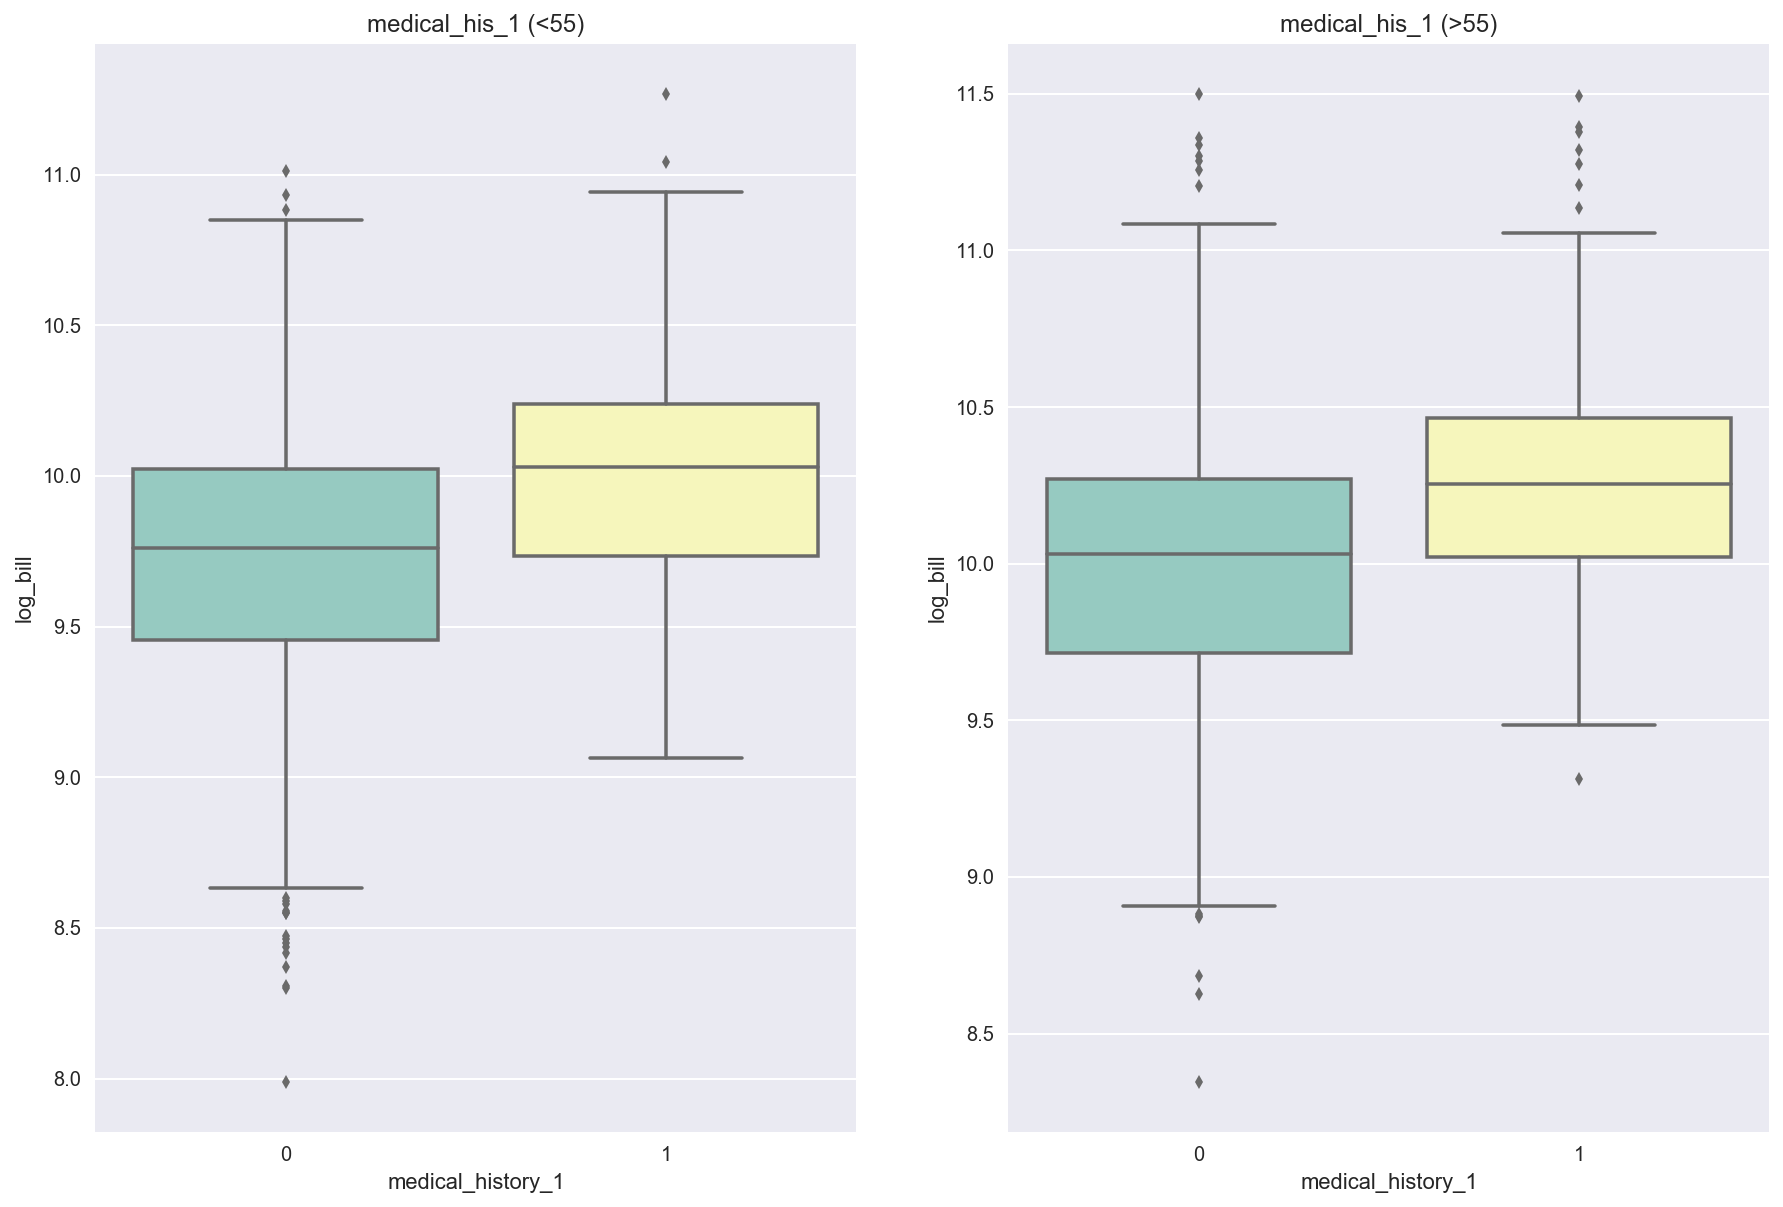


<55
Value Count:
medical_history_1
0    1503
1     302
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_1
0    18480.951772
1    23845.864172
Name: tot_bill_yr, dtype: float64

F: 113.1631232993799
P-value:  1.0036065443950259e-25
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass

##########################
>55
Value Count:
medical_history_1
0    1026
1     260
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_1
0    24203.101222
1    30329.863841
Name: tot_bill_yr, dtype: float64

F: 74.27498386072789
P-value:  1.8397113205612765e-17
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


/Users/joannasyeow/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/joannasyeow/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


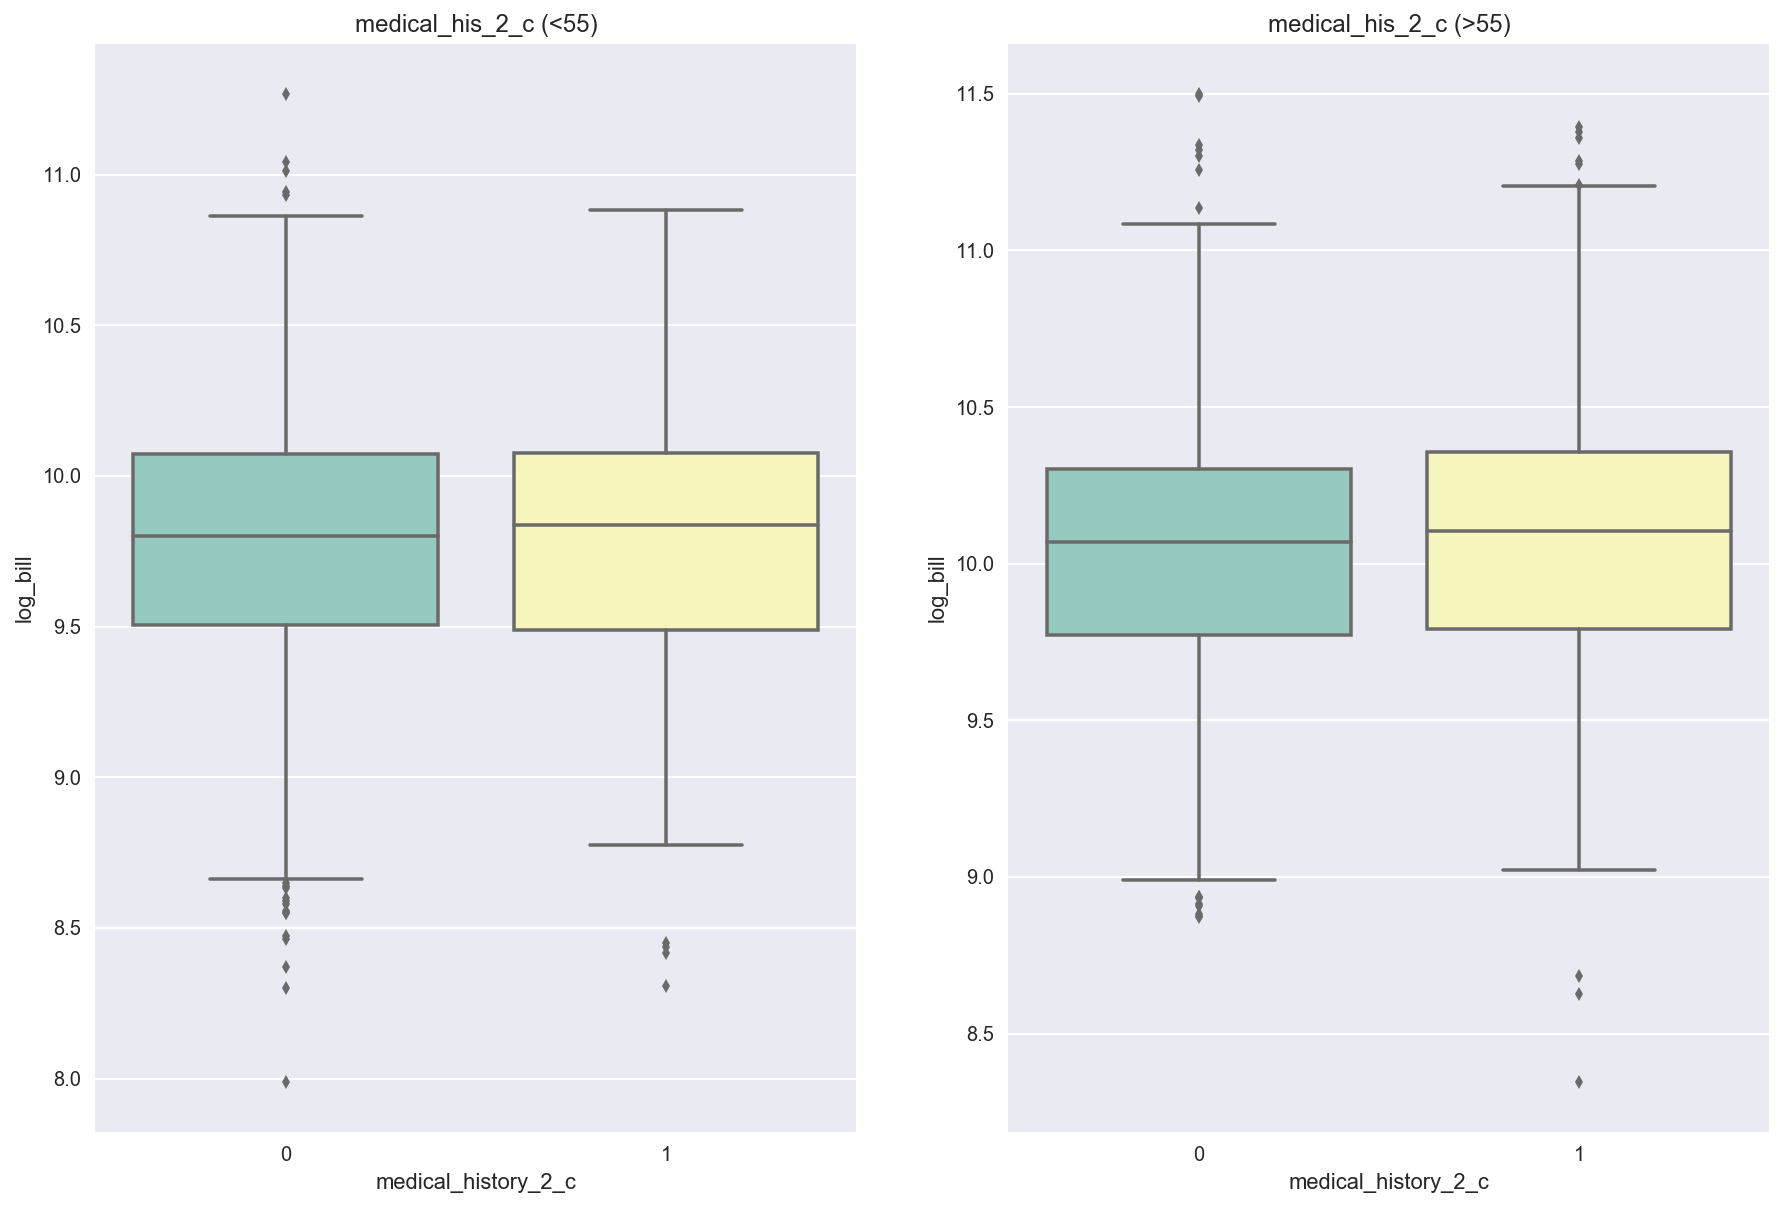


<55
Value Count:
medical_history_2_c
0    1297
1     537
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_2_c
0    19295.178051
1    19428.044955
Name: tot_bill_yr, dtype: float64

F: 0.3526241376519137
P-value:  0.5527007535850554
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.

##########################
>55
Value Count:
medical_history_2_c
0    882
1    417
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_2_c
0    25044.863907
1    26148.357282
Name: tot_bill_yr, dtype: float64

F: 1.712654198975243
P-value:  0.1908603705561119
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.


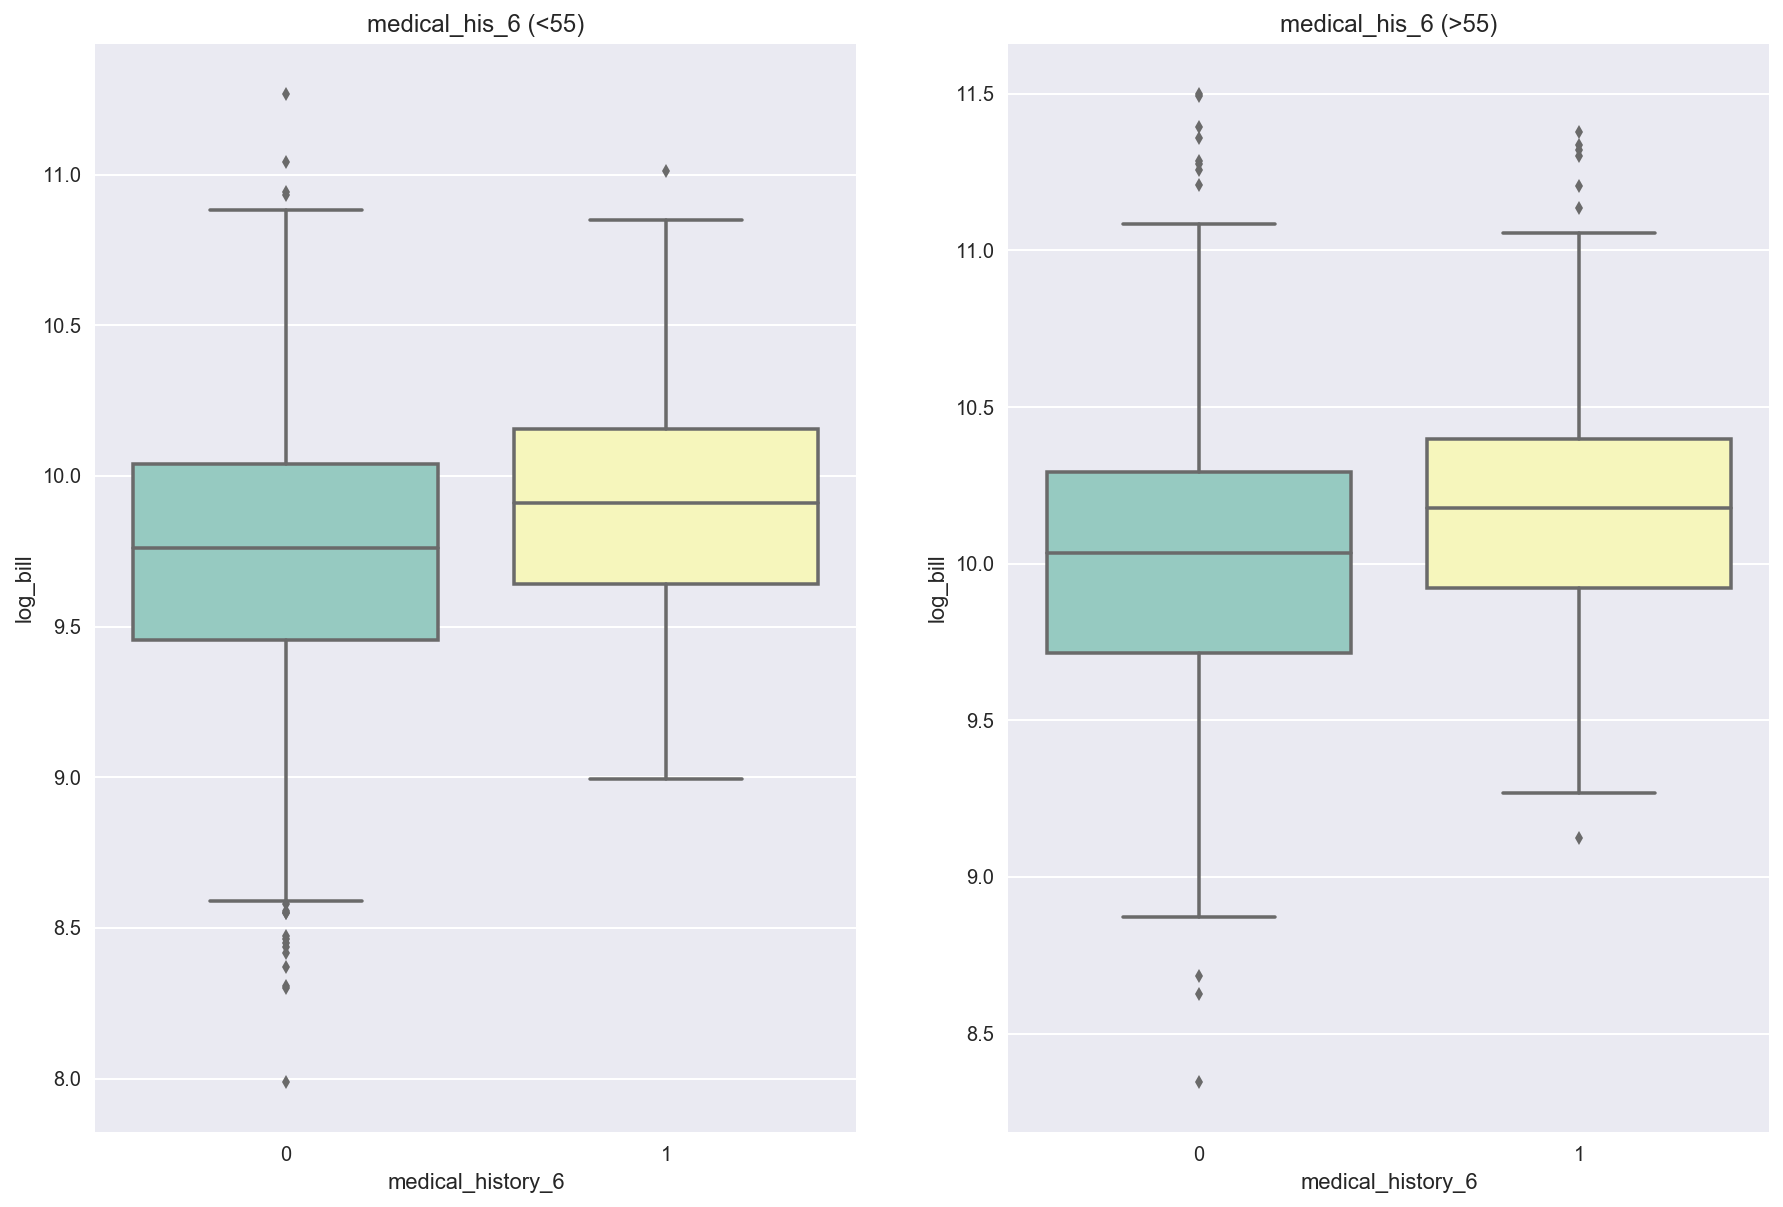


<55
Value Count:
medical_history_6
0    1327
1     506
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_6
0    18579.554036
1    21400.409691
Name: tot_bill_yr, dtype: float64

F: 56.21432475199219
P-value:  9.83466849010111e-14
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass

##########################
>55
Value Count:
medical_history_6
0    965
1    333
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_6
0    24398.096331
1    28379.384581
Name: tot_bill_yr, dtype: float64

F: 42.421071006155465
P-value:  1.0299500737454365e-10
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


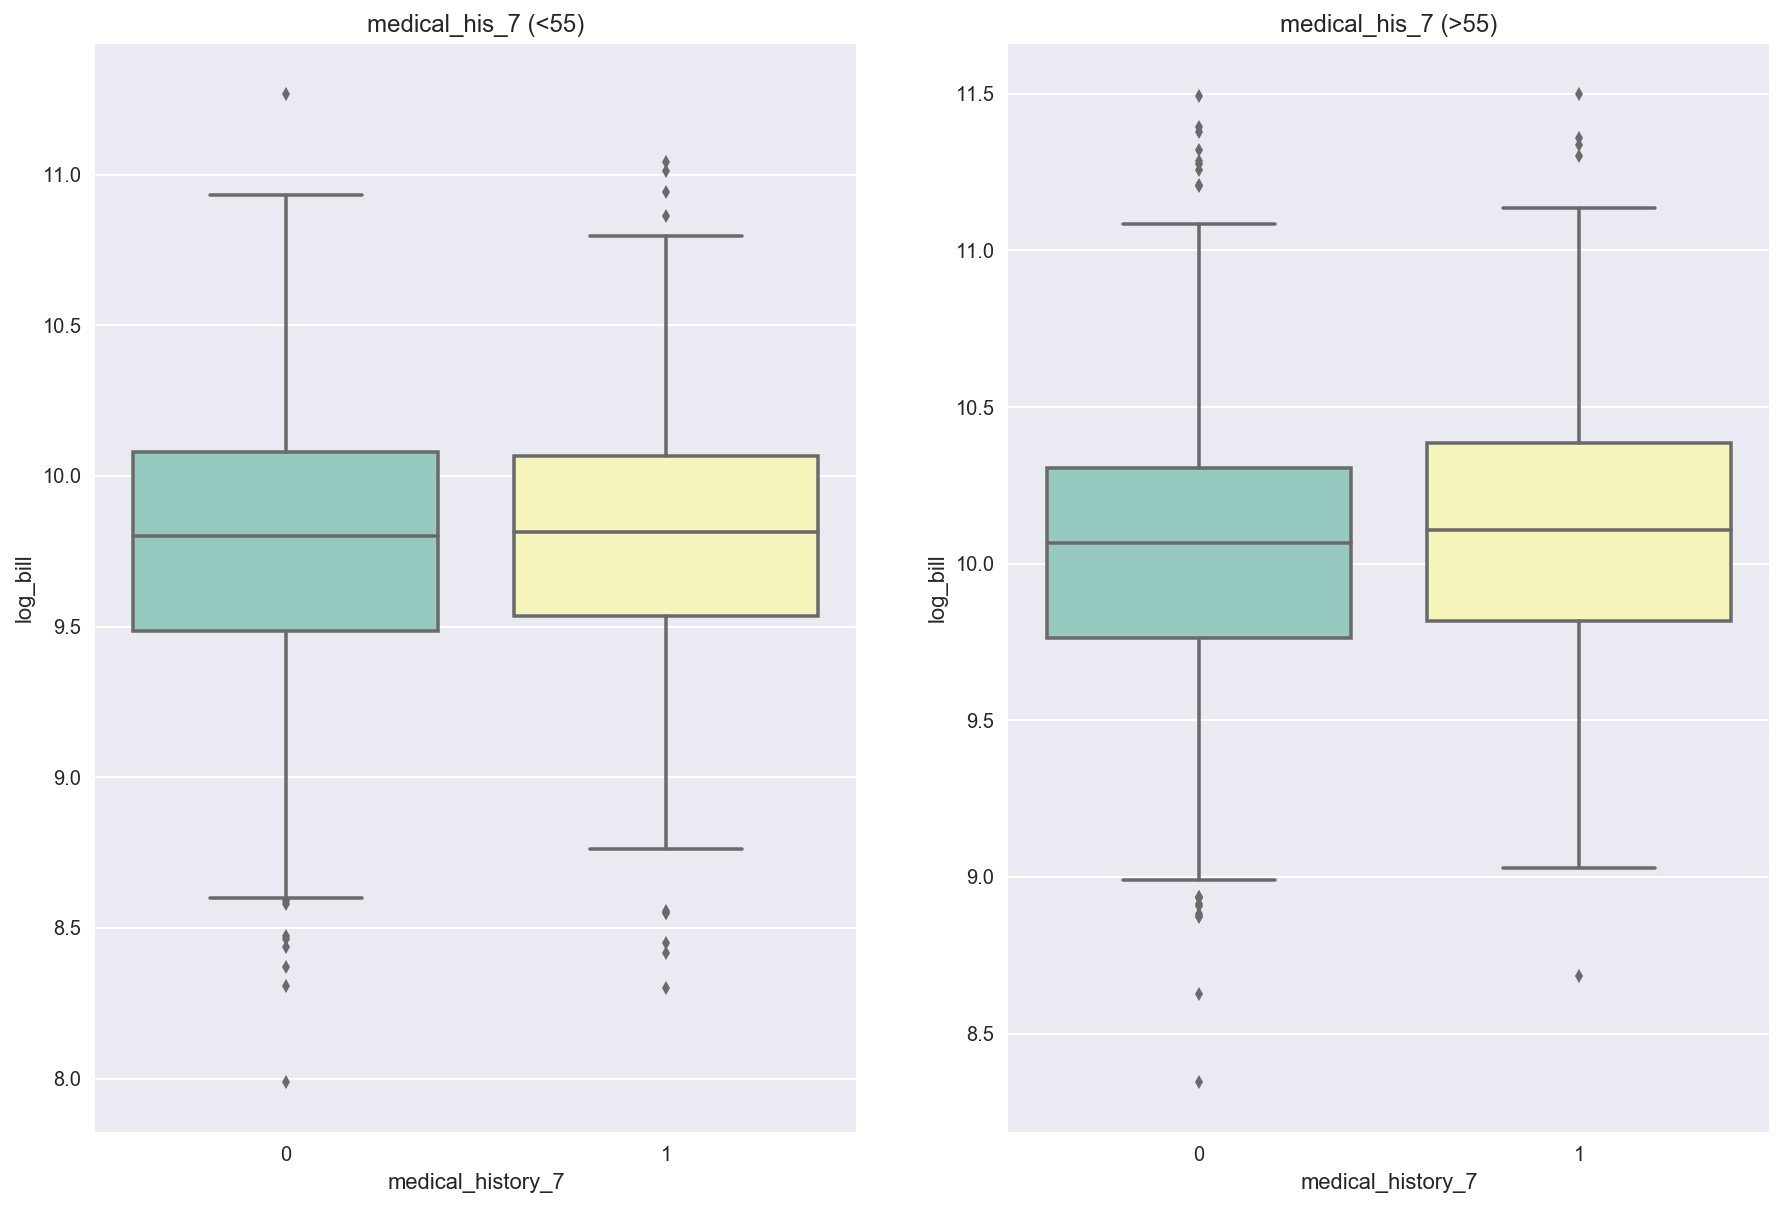


<55
Value Count:
medical_history_7
0    1331
1     496
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_7
0    19237.261081
1    19605.398248
Name: tot_bill_yr, dtype: float64

F: 0.6052338250282411
P-value:  0.4366830360321249
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.

##########################
>55
Value Count:
medical_history_7
0    950
1    346
Name: patient_id, dtype: int64

Mean Total Bills:
medical_history_7
0    24976.193680
1    26568.094597
Name: tot_bill_yr, dtype: float64

F: 6.11511495786123
P-value:  0.01352341662134493
Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.


In [24]:
for x in ['1','2_c','6','7']:

    fig, ax =plt.subplots(1,2)

    sns.boxplot(y=df[df['age_grp']==0]['log_bill'],x=df['medical_history_'+x], ax=ax[0],palette="Set3").set_title("medical_his_"+x+" (<55)")
    sns.boxplot(y=df[df['age_grp']==1]['log_bill'],x=df['medical_history_'+x], ax=ax[1],palette="Set3").set_title("medical_his_"+x+" (>55)")
    plt.show()

    print()
    print('<55')
    print('Value Count:')
    print(df[df['age_grp']==0].groupby('medical_history_'+x)['patient_id'].nunique())
    print()
    print('Mean Total Bills:')
    print(df[df['age_grp']==0].groupby('medical_history_'+x)['tot_bill_yr'].mean())
    print()
    
    # stats f_oneway function
    fvalue, pvalue = stats.f_oneway(df[df['age_grp']==0][df['medical_history_'+x] == 0]['log_bill'],df[df['age_grp']==0][df['medical_history_'+x] == 1]['log_bill'])
    print('F:',fvalue)
    print('P-value: ',pvalue)
    if pvalue < 0.01 :
        print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
        print('Hypothesis: Pass')
    else:
        print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')
    
    print()   
    print('##########################')    
    print('>55')
    print('Value Count:')
    print(df[df['age_grp']==1].groupby('medical_history_'+x)['patient_id'].nunique())
    print()
    print('Mean Total Bills:')
    print(df[df['age_grp']==1].groupby('medical_history_'+x)['tot_bill_yr'].mean())
    print()
    # stats f_oneway function
    fvalue, pvalue = stats.f_oneway(df[df['age_grp']==1][df['medical_history_'+x] == 0]['log_bill'],df[df['age_grp']==1][df['medical_history_'+x] == 1]['log_bill'])
    print('F:',fvalue)
    print('P-value: ',pvalue)
    if pvalue < 0.01 :
        print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
        print('Hypothesis: Pass')
    else:
        print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')
    

### BMI

mean bmi:  28.94840072420036


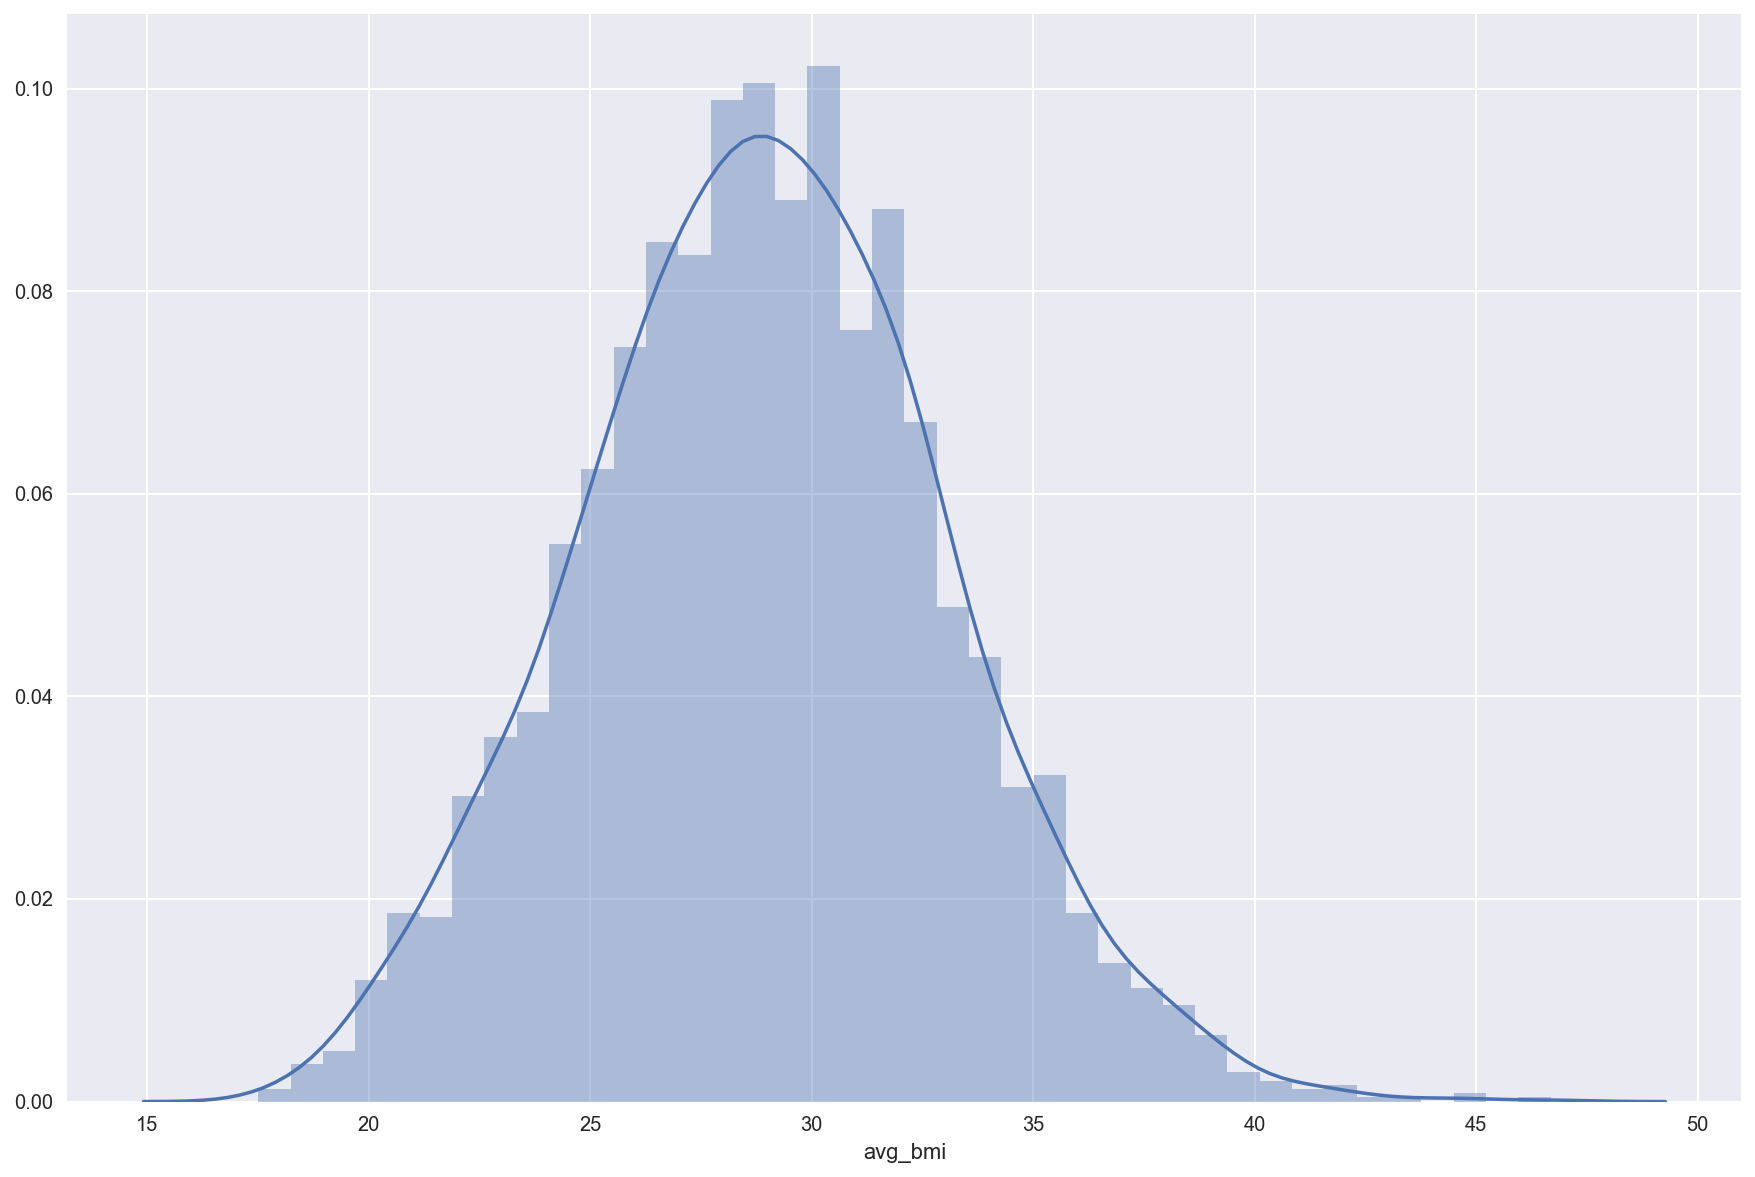

In [25]:
# distribution plot for bmi
print('mean bmi: ',np.mean(df['avg_bmi']))
sns.distplot(df['avg_bmi'])
plt.show()
print()

R:  0.1352982818994691
P-value:  5.2067012631101935e-15


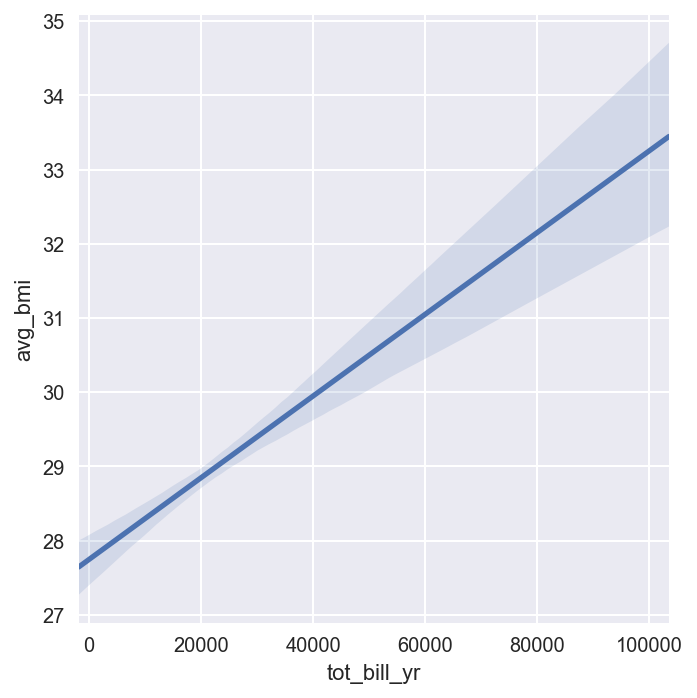

In [26]:
# Pearson Corrleation Coefficient on bmi
print ('R: ',stats.pearsonr(df['avg_bmi'], df['tot_bill_yr'])[0])
print ('P-value: ',stats.pearsonr(df['avg_bmi'], df['tot_bill_yr'])[1])

b = sns.lmplot(x='tot_bill_yr',y='avg_bmi',data=df,scatter=False)
plt.show()

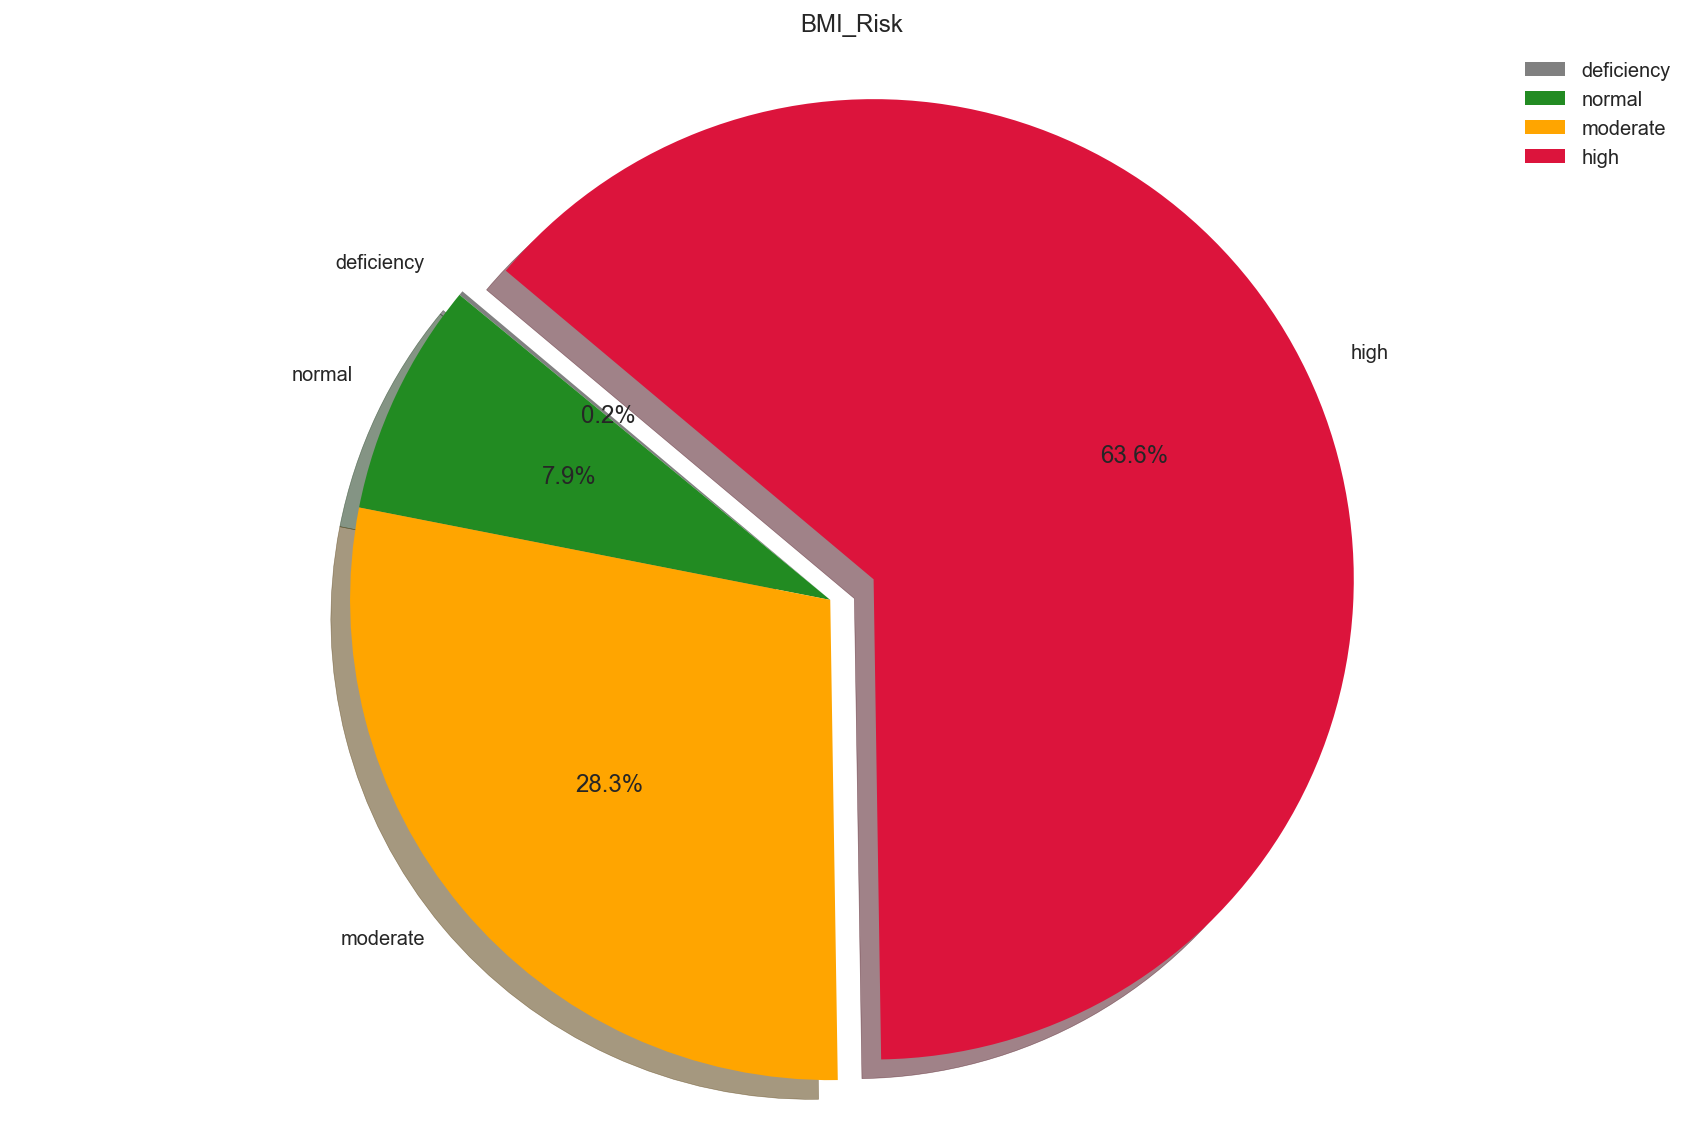

In [27]:
# sns.countplot(df['bmi_risk'])
# plt.show()

# Data to plot
labels = ['deficiency','normal','moderate','high']
sizes = [df[df['bmi_risk'] == 1]['patient_id'].count(),df[df['bmi_risk'] == 2]['patient_id'].count(),df[df['bmi_risk'] == 3]['patient_id'].count(),df[df['bmi_risk'] == 4]['patient_id'].count()]
colors = ['grey','forestgreen','orange','crimson']
explode = (0, 0,0,0.1)  # explode 1st slice

# colors=colors, explode=explode,                                                                                                        
                                                                                                       
# Plot
plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%', colors=colors, shadow=True, startangle=140)
 
plt.axis('equal')
plt.legend()
plt.title('BMI_Risk')

plt.show()

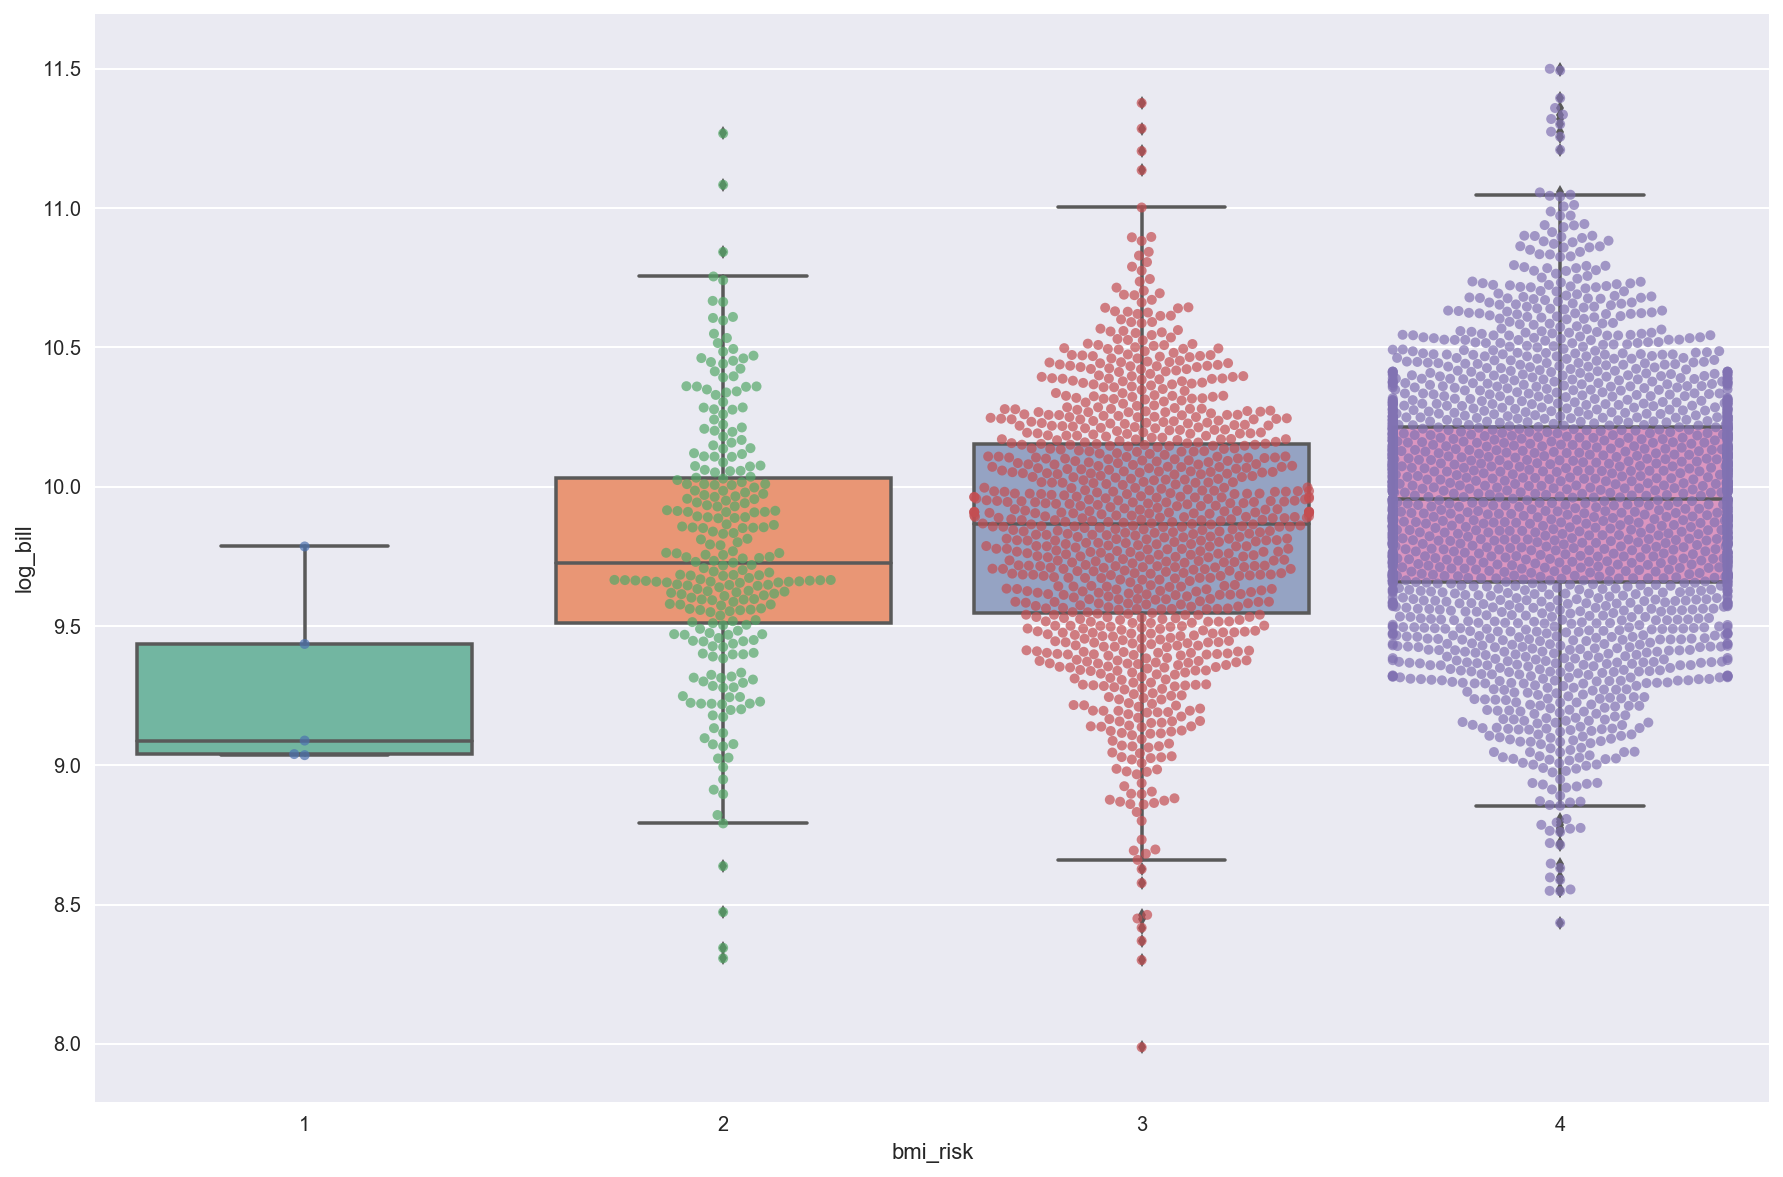

In [28]:
sns.boxplot(y=df['log_bill'],x=df['bmi_risk'],palette="Set2")
sns.swarmplot(y=df['log_bill'],x=df['bmi_risk'],alpha=0.7)

plt.show()

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.4923 0.0648 -0.0199 1.0045  False
     1      3   0.5664  0.022  0.0577  1.075   True
     1      4    0.656  0.005  0.1481 1.1639   True
     2      3    0.074 0.0778 -0.0053 0.1534  False
     2      4   0.1637  0.001  0.0893 0.2381   True
     3      4   0.0897  0.001  0.0451 0.1342   True
---------------------------------------------------


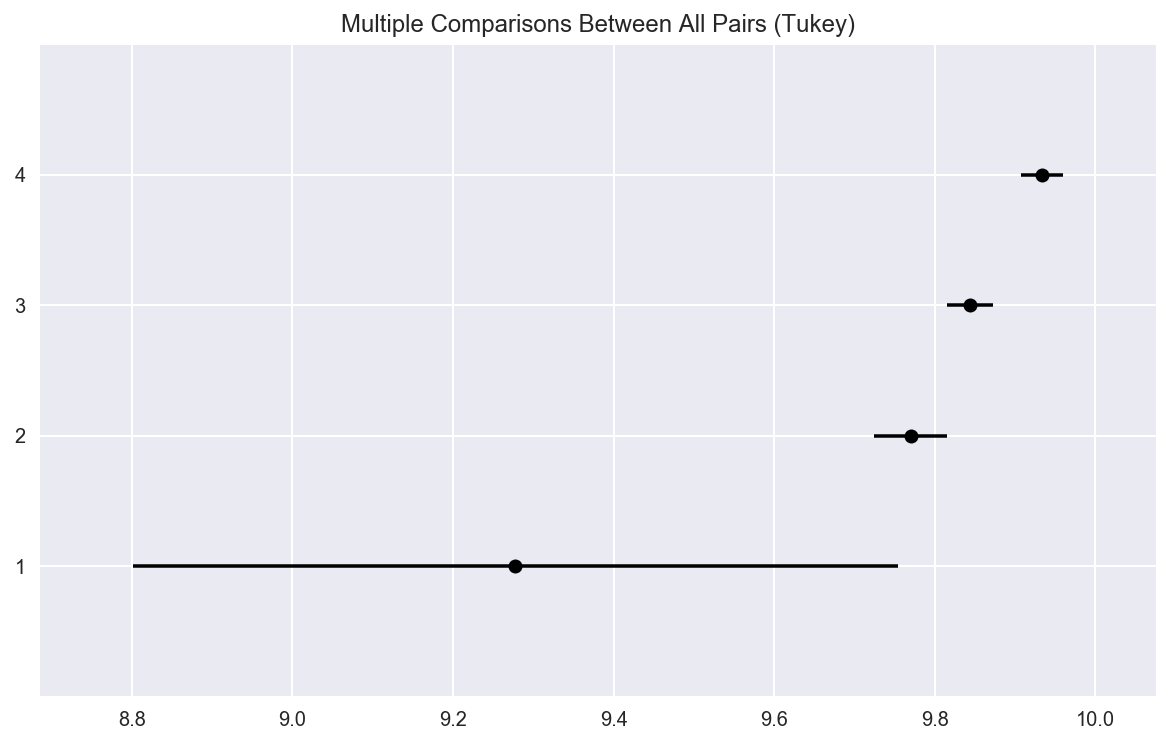

In [29]:
def tukey_hsd(df,col,aspect='log_bill'):

    # DataFrame.
    tukeyhsd = multi.pairwise_tukeyhsd(df[aspect].values,df[col].values, alpha=0.05)
    result = tukeyhsd.summary()
    print(result)

    #visualisation
    tukeyhsd.plot_simultaneous(figsize=(10,6))
    
tukey_hsd(df,'bmi_risk')

In [30]:
print()   
print('##########################')    
print('Value Count:')
print(df.groupby('bmi_risk')['patient_id'].nunique())
print()
print('Mean Total Bills:')
print(df.groupby('bmi_risk')['tot_bill_yr'].mean())
print()

# stats f_oneway function
fvalue, pvalue = stats.f_oneway(df[df['age_grp']==0][df['bmi_risk'] == 1]['log_bill'],df[df['age_grp']==0][df['bmi_risk'] == 2]['log_bill'],df[df['age_grp']==0][df['bmi_risk'] == 3]['log_bill'],df[df['age_grp']==0][df['bmi_risk'] == 4]['log_bill'])
print('F:',fvalue)
print('P-value: ',pvalue)
if pvalue < 0.01 :
    print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
    print('Hypothesis: Pass')
else:
    print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')


# stats f_oneway function
fvalue, pvalue = stats.f_oneway(df[df['age_grp']==1][df['bmi_risk'] == 1]['log_bill'],df[df['age_grp']==1][df['bmi_risk'] == 2]['log_bill'],df[df['age_grp']==1][df['bmi_risk'] == 3]['log_bill'],df[df['age_grp']==1][df['bmi_risk'] == 4]['log_bill'])
print('F:',fvalue)
print('P-value: ',pvalue)
if pvalue < 0.01 :
    print('Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.')
    print('Hypothesis: Pass')
else:
    print('Since pvalue is > 0.01, we are unable to reject the null hypothesis at 0.01 significance level. We conclude that there is insufficient evidence to claim that two or more groups do not have the same population mean.')



##########################
Value Count:
bmi_risk
1       5
2     240
3     870
4    1917
Name: patient_id, dtype: int64

Mean Total Bills:
bmi_risk
1    11200.494000
2    19389.946801
3    20774.032691
4    22651.657781
Name: tot_bill_yr, dtype: float64

F: 10.34476489773523
P-value:  9.384113813376717e-07
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass
F: 13.58149482196853
P-value:  9.828767357814275e-09
Since pvalue is < 0.01, we reject the null hypothesis that two or more groups have the same population mean at 0.01 significance level.
Hypothesis: Pass


/Users/joannasyeow/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/Users/joannasyeow/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


# Defining selected variables

In [31]:
X = df[['medical_history_1','medical_history_6','bmi_high','age_grp','foreigner','malay']]
y = df['tot_bill_yr']
y_lg = df['log_bill']

# Variance Inflation Factor

To check for multicolinearity

In [32]:
# Variance Inflation Factor to check for multicolinearity

# gather features
features = "+".join(X.columns)

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif.round()

,VIF Factor,features
0,1.0,medical_history_1
1,1.0,medical_history_6
2,2.0,bmi_high
3,1.0,age_grp
4,1.0,foreigner
5,1.0,malay


# Linear Regression Model

Y = β0 + β1 medical history 1 + β2 medical history 6 + β3 high bmi + β4 age > 55 + β5 foreigner + β6 malay

In [33]:
# Using Statsmodel

X = df[['medical_history_1','medical_history_6','bmi_high','age_grp','foreigner','malay']].to_numpy()
y = np.log(df['tot_bill_yr']).to_numpy()

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     388.6
Date:                Tue, 21 Sep 2021   Prob (F-statistic):               0.00
Time:                        00:18:25   Log-Likelihood:                -1135.1
No. Observations:                3314   AIC:                             2284.
Df Residuals:                    3307   BIC:                             2327.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.5195      0.012    773.250      0.0

In [34]:
import math

print ('Average total bill per year for patients with condition X and medical history 1 is ~', round ((math.exp(est2.params[1]) - 1) * 100,2),'% higher when compared to patients without' )
print ('Average total bill per year for patients with condition X and medical history 6 is ~', round ((math.exp(est2.params[2]) - 1) * 100,2),'% higher when compared to patients without' )
print ("Average total bill per year for patients with condition X and high bmi is ~", round ((math.exp(est2.params[3]) - 1) * 100,2),"% higher when compared to patients doesn't" )
print ('Average total bill per year for patients with condition X > 55 years old is ~', round ((math.exp(est2.params[4]) - 1) * 100,2),'% higher when compared to patients < 55' )
print ('Average total bill per year for foreigner patients with condition X is ~', round ((math.exp(est2.params[5]) - 1) * 100,2),'% higher when compared to patients who are Singaporeans or PR' )
print ('Average total bill per year for malay patients with condition X is ~', round ((math.exp(est2.params[6]) - 1) * 100,2),'% higher when compared to patients of other races' )

# https://stats.idre.ucla.edu/sas/faq/how-can-i-interpret-log-transformed-variables-in-terms-of-percent-change-in-linear-regression/

Average total bill per year for patients with condition X and medical history 1 is ~ 29.11 % higher when compared to patients without
Average total bill per year for patients with condition X and medical history 6 is ~ 18.71 % higher when compared to patients without
Average total bill per year for patients with condition X and high bmi is ~ 11.38 % higher when compared to patients doesn't
Average total bill per year for patients with condition X > 55 years old is ~ 27.86 % higher when compared to patients < 55
Average total bill per year for foreigner patients with condition X is ~ 96.83 % higher when compared to patients who are Singaporeans or PR
Average total bill per year for malay patients with condition X is ~ 49.05 % higher when compared to patients of other races


# Decision Tree Model

In [35]:
X = df[['medical_history_1','medical_history_6','medical_history_7','bmi_high','age_grp','foreigner','malay']]
y = df['tot_bill_yr']

regr = DecisionTreeRegressor(random_state=222,max_depth=7)
regr.fit(X,y)

print ('R2 Score: ', regr.score(X,y) )

impt = pd.DataFrame(index=X.columns)
impt['impt'] = regr.feature_importances_
impt = impt.sort_values('impt',ascending=False)

R2 Score:  0.5611903854372494


In [36]:
impt

,impt
foreigner,0.347893
malay,0.291261
age_grp,0.147948
medical_history_1,0.087008
medical_history_6,0.054680
bmi_high,0.038039
medical_history_7,0.033171


In [37]:
import graphviz
dot_data = tree.export_graphviz(regr, out_file=None, 
                                feature_names=X.columns,  
                                filled=True)
graph = graphviz.Source(dot_data, format="png") 

NameError: name 'tree' is not defined

In [ ]:
graph.render("decision_tree_graphivz")

In [ ]:
graph